In [1]:
import os
import json
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix
from scipy.interpolate import interp1d
from scipy.spatial import distance
from tqdm import tqdm
from itertools import product, chain

In [2]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# 랜드마크 인덱스 정의 # 11개
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]
FRAME_INTERVAL = 6
VID_LEN = 600
FRAMES = list(range(0, VID_LEN, FRAME_INTERVAL))
CLASS_LIST = ['Normal', 'Danger', 'Fall']
DR = 'E'
pt_path = DR + r':\project\CVProject\results\result_pt_JKH\norm_x'
train_size, valid_size, test_size = 0.8, 0.1, 0.1

In [4]:
def fill_missing_data(data):
    frame_exist_list = [int(x.split('_')[-1]) for x in data['pose_data']]
    key_list = list(map(lambda x: CLASS_LIST.index(x['class']), data['pose_data'].values()))
    pose_list = list(map(lambda x: list(chain(*[list(v.values()) for k, v in x.items() if 'landmark' in k])), data['pose_data'].values()))
    bbox_list = list(map(lambda x: list(chain(*[list(v.values()) for k, v in x.items() if k == 'bbox'])), data['pose_data'].values()))

    key = list(interp1d(frame_exist_list, key_list, kind='nearest-up', fill_value='extrapolate')(FRAMES))
    pose = list(interp1d(frame_exist_list, pose_list, kind='linear', fill_value='extrapolate', axis=0)(FRAMES))
    bbox = list(interp1d(frame_exist_list, bbox_list, kind='linear', fill_value='extrapolate', axis=0)(FRAMES))

    new_data = {
        f'frame_{i}': {
            f'landmark_{k}': {
                'x': pose[idx_i][2*idx_k+0],
                'y': pose[idx_i][2*idx_k+1],
            } for idx_k, k in enumerate(LANDMARKS)
        } for idx_i, i in enumerate(FRAMES)
    }
    for idx_i, i in enumerate(FRAMES):
        new_data[f'frame_{i}'].update({'bbox':{'x1': bbox[idx_i][0], 'y1': bbox[idx_i][1], 'x2': bbox[idx_i][2], 'y2': bbox[idx_i][3]}, 
                                       'class': CLASS_LIST[int(key[idx_i])]})
    return new_data

In [5]:
# 바운딩 박스 비율 클래스 정의 함수
def bbox_ratio_class(ratio):
    if ratio < 0.7:
        return 0  # Normal 가능성 높은 class
    else:
        return 1  # Danger or Fall 가능성 높은 class

# YOLO xy 비율 계산 함수
def calculate_yolo_xy_ratio(frame):
    bbox = frame.get('bbox', None)
    if bbox and (bbox['x2'] - bbox['x1']) != 0:
        yolo_xy_ratio = round((bbox['y2'] - bbox['y1']) / (bbox['x2'] - bbox['x1']), 3)
    else:
        yolo_xy_ratio = 0.0
    return yolo_xy_ratio

In [6]:
# 머리 및 상체 속도 계산 함수 (시퀀스 평균값 사용)
def calculate_head_upper_body_speed(sequence):
    speeds = []
    for j in range(1, len(sequence)):
        keypoints = sequence[j]
        prev_keypoints = sequence[j - 1]
        h = np.array([keypoints.get(f'landmark_0', {}).get('x', 0.0), keypoints.get(f'landmark_0', {}).get('y', 0.0)])
        l = np.array([keypoints.get(f'landmark_11', {}).get('x', 0.0), keypoints.get(f'landmark_11', {}).get('y', 0.0)])
        r = np.array([keypoints.get(f'landmark_12', {}).get('x', 0.0), keypoints.get(f'landmark_12', {}).get('y', 0.0)])

        # 이전 프레임의 좌표
        prev_h = np.array([prev_keypoints.get(f'landmark_0', {}).get('x', 0.0), prev_keypoints.get(f'landmark_0', {}).get('y', 0.0)])
        prev_l = np.array([prev_keypoints.get(f'landmark_11', {}).get('x', 0.0), prev_keypoints.get(f'landmark_11', {}).get('y', 0.0)])
        prev_r = np.array([prev_keypoints.get(f'landmark_12', {}).get('x', 0.0), prev_keypoints.get(f'landmark_12', {}).get('y', 0.0)])

        # 현재 프레임과 이전 프레임의 상체 중심
        center_new = (h + l + r) / 3
        center_prev = (prev_h + prev_l + prev_r) / 3

        # 유클리드 거리 계산 (6프레임당 일정하므로 속력이라 봐도 무방함)
        dist_new = distance.euclidean(center_new, center_prev)
        speeds.append(dist_new)

    # 평균 속력 계산
    if speeds:
        return sum(speeds) / len(speeds)
    else:
        return 0.0

In [7]:
# 데이터셋 클래스 정의
# 현재 input은 mediapipe의 관절 좌표값 22개 + YOLO xy ratio + bbox_ratio_class + 머리/상체 속도 => 25개
class FallSequenceDataset(Dataset):
    def __init__(self, json_files, sequence_length=3, input_config='full'):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        self.scaler = StandardScaler()
        self.input_config = input_config

        all_landmarks = []

        for json_file in tqdm(json_files, desc="Processing JSON files"):
            with open(json_file, 'r') as f:
                data = json.load(f)

            if len(data['pose_data']) < 90:
                    continue
            
            data['pose_data'] = fill_missing_data(data)

            frames = list(data['pose_data'].values())

            for i in range(0, len(frames) - self.sequence_length + 1, self.sequence_length):
                sequence = frames[i:i + self.sequence_length]
                landmarks = []

                # YOLO xy ratio 및 바운딩 박스 클래스는 시퀀스마다 1개씩만 추가
                yolo_xy_ratio = calculate_yolo_xy_ratio(sequence[-1])  # 마지막 프레임 기준으로 계산
                ratio_class = bbox_ratio_class(yolo_xy_ratio)
                head_torso_speed = calculate_head_upper_body_speed(sequence)

                for j, frame in enumerate(sequence):
                    frame_landmarks = []
                    if frame is not None:
                        if self.input_config in ['full', 'mediapipe']:
                            for landmark in LANDMARKS:
                                landmark_data = frame.get(f'landmark_{landmark}', None)
                                if landmark_data:
                                    frame_landmarks.extend([
                                        round(landmark_data['x'], 3),  # 소수점 세 자리로 반올림
                                        round(landmark_data['y'], 3)
                                    ])
                                else:
                                    frame_landmarks.extend([0.0, 0.0])

                        if self.input_config in ['full', 'simplified']:
                            # YOLO xy ratio, 바운딩 박스 클래스, 머리/상체 속도 추가 (시퀀스 단위로 동일 값 사용)
                            frame_landmarks.append(yolo_xy_ratio)
                            frame_landmarks.append(ratio_class)
                            frame_landmarks.append(head_torso_speed)
                    
                    landmarks.append(frame_landmarks)

                # 데이터 증강 없이 원래 데이터를 사용
                all_landmarks.extend(landmarks)

                # 레이블 재정의
                if sequence[-1]['class'] == 'Normal':
                    label = 0  # 비낙상
                elif sequence[-1]['class'] == 'Danger':
                    label = 1  # 낙상 위험
                elif sequence[-1]['class'] == 'Fall':
                    label = 2  # 완전 낙상

                self.sequences.append(landmarks)
                self.labels.append(label)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.LongTensor([self.labels[idx]]).squeeze()

In [8]:
# GRU 기반 낙상 감지 모델 정의
class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=3):
        super(FallDetectionGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(2, x.size(0), 128).to(x.device)  # 초기 은닉 상태 정의
        out, _ = self.gru(x, h_0)
        out = self.fc(out[:, -1, :])  # 마지막 time step의 출력을 사용
        return out

In [9]:
# 검증 및 테스트 데이터셋 로드 경로
json_folder = r'E:\json_6_tvt'

# 각 데이터 폴더에서 JSON 파일 목록 생성
json_files = [os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')]


# 데이터셋 생성 (입력 데이터 설정에 따라)
full_dataset = FallSequenceDataset(json_files, input_config='full')
dataset_size = len(full_dataset)
train_size = int(dataset_size*0.8)
valid_size = int(dataset_size*0.1)
test_size = dataset_size - train_size - valid_size
simplified_dataset = FallSequenceDataset(json_files, input_config='simplified')
mediapipe_dataset = FallSequenceDataset(json_files, input_config='mediapipe')

train_full_dataset, valid_full_dataset, test_full_dataset = random_split(full_dataset, [train_size, valid_size, test_size])
train_simplified_dataset, valid_simplified_dataset, test_simplified_dataset = random_split(simplified_dataset, [train_size, valid_size, test_size])
train_mediapipe_dataset, valid_mediapipe_dataset, test_mediapipe_dataset = random_split(mediapipe_dataset, [train_size, valid_size, test_size])

# 데이터 로더 생성
train_loader_full = DataLoader(train_full_dataset, batch_size=32, shuffle=True)
valid_loader_full = DataLoader(valid_full_dataset, batch_size=32, shuffle=False)
test_loader_full = DataLoader(test_full_dataset, batch_size=32, shuffle=False)

train_loader_simplified = DataLoader(train_simplified_dataset, batch_size=32, shuffle=True)
valid_loader_simplified = DataLoader(valid_simplified_dataset, batch_size=32, shuffle=False)
test_loader_simplified = DataLoader(test_simplified_dataset, batch_size=32, shuffle=False)

train_loader_mediapipe = DataLoader(train_mediapipe_dataset, batch_size=32, shuffle=True)
valid_loader_mediapipe = DataLoader(valid_mediapipe_dataset, batch_size=32, shuffle=False)
test_loader_mediapipe = DataLoader(test_mediapipe_dataset, batch_size=32, shuffle=False)

Processing JSON files:   0%|          | 0/2024 [00:00<?, ?it/s]

Processing JSON files: 100%|██████████| 2024/2024 [00:14<00:00, 135.24it/s]


In [10]:
# 클래스 가중치 계산 및 손실 함수 정의 (훈련 데이터셋 기준)
class_weights = compute_class_weight('balanced', classes=np.unique(full_dataset.labels), y=full_dataset.labels)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 모델 준비
def create_model_for_dataset(dataset):
    if len(dataset) > 0:
        sample_sequence, sample_label = dataset[0]
        input_size = len(sample_sequence[0])  # 시퀀스 내의 각 프레임에서 입력의 길이를 가져옴
        return FallDetectionGRU(input_size).to(device)
    else:
        print("데이터 없음")
        exit()

# 학습 파라미터 설정
num_epochs = 500
best_loss = float('inf')
patience = 50
no_improve = 0

In [11]:
# 학습 루프
for train_loader, valid_loader, model_name, dataset, lr in [
    (train_loader_full, valid_loader_full, 'normx_best_fall_detection_gru_001_full.pt', train_full_dataset, 0.001),
    (train_loader_full, valid_loader_full, 'normx_best_fall_detection_gru_0001_full.pt', train_full_dataset, 0.0001),
    (train_loader_simplified, valid_loader_simplified, 'normx_best_fall_detection_gru_0001_simplified.pt', train_simplified_dataset, 0.0001),
    (train_loader_mediapipe, valid_loader_mediapipe, 'normx_best_fall_detection_gru_0001_mediapipe.pt', train_mediapipe_dataset, 0.0001)
]:
    # 모델을 새로 생성
    model = create_model_for_dataset(dataset)
    model.to(device)

    # 옵티마이저와 스케줄러 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0
    
    print(f"{model_name} 학습 시작", flush=True)
    print("\n" + "=" * 20 + f" Training Configuration: GRU with input_config='{model_name[:-3].split('_')[-1]}' and lr='{optimizer.param_groups[0]['lr']}' " + "=" * 20 + "\n")

    # 입력 크기 체크 (훈련 시작 시 1회만 출력)
    sequences, labels = next(iter(train_loader))
    print(f'현재 입력 크기 (마지막 차원): {sequences.size(-1)}')
    print(f'예상 입력 크기: {model.gru.input_size}')

    for epoch in range(num_epochs):
        model.train()
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()
            
            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}')

        # 검증 데이터셋 평가
        model.eval()
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), f'{pt_path}\\{model_name}')
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

normx_best_fall_detection_gru_001_full.pt 학습 시작

==================== Training Configuration: GRU with input_config='full' and lr='0.001' ====================

현재 입력 크기 (마지막 차원): 25
예상 입력 크기: 25


Epoch 1/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.90it/s]


Epoch [1/500], Train Loss: 0.6480
Epoch [1/500], Valid Loss: 0.6378


Epoch 2/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.21it/s]


Epoch [2/500], Train Loss: 0.5060
Epoch [2/500], Valid Loss: 0.4732


Epoch 3/500: 100%|██████████| 1608/1608 [00:03<00:00, 504.08it/s]


Epoch [3/500], Train Loss: 0.4621
Epoch [3/500], Valid Loss: 0.4618


Epoch 4/500: 100%|██████████| 1608/1608 [00:03<00:00, 499.98it/s]


Epoch [4/500], Train Loss: 0.4439
Epoch [4/500], Valid Loss: 0.4533


Epoch 5/500: 100%|██████████| 1608/1608 [00:03<00:00, 507.41it/s]


Epoch [5/500], Train Loss: 0.4356
Epoch [5/500], Valid Loss: 0.4026


Epoch 6/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.92it/s]


Epoch [6/500], Train Loss: 0.4272
Epoch [6/500], Valid Loss: 0.3916


Epoch 7/500: 100%|██████████| 1608/1608 [00:03<00:00, 498.92it/s]


Epoch [7/500], Train Loss: 0.4180
Epoch [7/500], Valid Loss: 0.4182


Epoch 8/500: 100%|██████████| 1608/1608 [00:03<00:00, 502.82it/s]


Epoch [8/500], Train Loss: 0.4135
Epoch [8/500], Valid Loss: 0.4252


Epoch 9/500: 100%|██████████| 1608/1608 [00:03<00:00, 485.95it/s]


Epoch [9/500], Train Loss: 0.4032
Epoch [9/500], Valid Loss: 0.4137


Epoch 10/500: 100%|██████████| 1608/1608 [00:03<00:00, 499.38it/s]


Epoch [10/500], Train Loss: 0.4030
Epoch [10/500], Valid Loss: 0.4069


Epoch 11/500: 100%|██████████| 1608/1608 [00:03<00:00, 496.14it/s]


Epoch [11/500], Train Loss: 0.3981
Epoch [11/500], Valid Loss: 0.3854


Epoch 12/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.09it/s]


Epoch [12/500], Train Loss: 0.3949
Epoch [12/500], Valid Loss: 0.3786


Epoch 13/500: 100%|██████████| 1608/1608 [00:03<00:00, 504.67it/s]


Epoch [13/500], Train Loss: 0.3905
Epoch [13/500], Valid Loss: 0.3843


Epoch 14/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.57it/s]


Epoch [14/500], Train Loss: 0.3872
Epoch [14/500], Valid Loss: 0.3942


Epoch 15/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.46it/s]


Epoch [15/500], Train Loss: 0.3803
Epoch [15/500], Valid Loss: 0.3961


Epoch 16/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.96it/s]


Epoch [16/500], Train Loss: 0.3782
Epoch [16/500], Valid Loss: 0.3696


Epoch 17/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.79it/s]


Epoch [17/500], Train Loss: 0.3769
Epoch [17/500], Valid Loss: 0.4036


Epoch 18/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.46it/s]


Epoch [18/500], Train Loss: 0.3750
Epoch [18/500], Valid Loss: 0.4213


Epoch 19/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.94it/s]


Epoch [19/500], Train Loss: 0.3701
Epoch [19/500], Valid Loss: 0.3593


Epoch 20/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.67it/s]


Epoch [20/500], Train Loss: 0.3695
Epoch [20/500], Valid Loss: 0.3850


Epoch 21/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.70it/s]


Epoch [21/500], Train Loss: 0.3640
Epoch [21/500], Valid Loss: 0.3711


Epoch 22/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.58it/s]


Epoch [22/500], Train Loss: 0.3614
Epoch [22/500], Valid Loss: 0.4269


Epoch 23/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.56it/s]


Epoch [23/500], Train Loss: 0.3606
Epoch [23/500], Valid Loss: 0.3798


Epoch 24/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.06it/s]


Epoch [24/500], Train Loss: 0.3596
Epoch [24/500], Valid Loss: 0.3881


Epoch 25/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.71it/s]


Epoch [25/500], Train Loss: 0.3556
Epoch [25/500], Valid Loss: 0.3695


Epoch 26/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.37it/s]


Epoch [26/500], Train Loss: 0.3199
Epoch [26/500], Valid Loss: 0.3349


Epoch 27/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.47it/s]


Epoch [27/500], Train Loss: 0.3167
Epoch [27/500], Valid Loss: 0.3355


Epoch 28/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.88it/s]


Epoch [28/500], Train Loss: 0.3149
Epoch [28/500], Valid Loss: 0.3364


Epoch 29/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.04it/s]


Epoch [29/500], Train Loss: 0.3141
Epoch [29/500], Valid Loss: 0.3310


Epoch 30/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.41it/s]


Epoch [30/500], Train Loss: 0.3118
Epoch [30/500], Valid Loss: 0.3312


Epoch 31/500: 100%|██████████| 1608/1608 [00:03<00:00, 511.85it/s]


Epoch [31/500], Train Loss: 0.3126
Epoch [31/500], Valid Loss: 0.3381


Epoch 32/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.91it/s]


Epoch [32/500], Train Loss: 0.3111
Epoch [32/500], Valid Loss: 0.3431


Epoch 33/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.39it/s]


Epoch [33/500], Train Loss: 0.3097
Epoch [33/500], Valid Loss: 0.3296


Epoch 34/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.24it/s]


Epoch [34/500], Train Loss: 0.3087
Epoch [34/500], Valid Loss: 0.3313


Epoch 35/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.06it/s]


Epoch [35/500], Train Loss: 0.3077
Epoch [35/500], Valid Loss: 0.3285


Epoch 36/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.37it/s]


Epoch [36/500], Train Loss: 0.3073
Epoch [36/500], Valid Loss: 0.3334


Epoch 37/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.29it/s]


Epoch [37/500], Train Loss: 0.3063
Epoch [37/500], Valid Loss: 0.3353


Epoch 38/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.53it/s]


Epoch [38/500], Train Loss: 0.3055
Epoch [38/500], Valid Loss: 0.3317


Epoch 39/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.70it/s]


Epoch [39/500], Train Loss: 0.3030
Epoch [39/500], Valid Loss: 0.3379


Epoch 40/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.21it/s]


Epoch [40/500], Train Loss: 0.3046
Epoch [40/500], Valid Loss: 0.3362


Epoch 41/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.14it/s]


Epoch [41/500], Train Loss: 0.3035
Epoch [41/500], Valid Loss: 0.3304


Epoch 42/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.26it/s]


Epoch [42/500], Train Loss: 0.2968
Epoch [42/500], Valid Loss: 0.3271


Epoch 43/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.21it/s]


Epoch [43/500], Train Loss: 0.2968
Epoch [43/500], Valid Loss: 0.3273


Epoch 44/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.38it/s]


Epoch [44/500], Train Loss: 0.2977
Epoch [44/500], Valid Loss: 0.3264


Epoch 45/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.10it/s]


Epoch [45/500], Train Loss: 0.2972
Epoch [45/500], Valid Loss: 0.3262


Epoch 46/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.73it/s]


Epoch [46/500], Train Loss: 0.2953
Epoch [46/500], Valid Loss: 0.3264


Epoch 47/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.13it/s]


Epoch [47/500], Train Loss: 0.2961
Epoch [47/500], Valid Loss: 0.3274


Epoch 48/500: 100%|██████████| 1608/1608 [00:03<00:00, 509.91it/s]


Epoch [48/500], Train Loss: 0.2965
Epoch [48/500], Valid Loss: 0.3266


Epoch 49/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.46it/s]


Epoch [49/500], Train Loss: 0.2957
Epoch [49/500], Valid Loss: 0.3262


Epoch 50/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.21it/s]


Epoch [50/500], Train Loss: 0.2954
Epoch [50/500], Valid Loss: 0.3272


Epoch 51/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.45it/s]


Epoch [51/500], Train Loss: 0.2959
Epoch [51/500], Valid Loss: 0.3266


Epoch 52/500: 100%|██████████| 1608/1608 [00:03<00:00, 510.96it/s]


Epoch [52/500], Train Loss: 0.2958
Epoch [52/500], Valid Loss: 0.3262


Epoch 53/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.13it/s]


Epoch [53/500], Train Loss: 0.2959
Epoch [53/500], Valid Loss: 0.3262


Epoch 54/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.95it/s]


Epoch [54/500], Train Loss: 0.2942
Epoch [54/500], Valid Loss: 0.3262


Epoch 55/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.10it/s]


Epoch [55/500], Train Loss: 0.2955
Epoch [55/500], Valid Loss: 0.3262


Epoch 56/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.07it/s]


Epoch [56/500], Train Loss: 0.2965
Epoch [56/500], Valid Loss: 0.3261


Epoch 57/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.79it/s]


Epoch [57/500], Train Loss: 0.2950
Epoch [57/500], Valid Loss: 0.3262


Epoch 58/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.08it/s]


Epoch [58/500], Train Loss: 0.2946
Epoch [58/500], Valid Loss: 0.3263


Epoch 59/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.88it/s]


Epoch [59/500], Train Loss: 0.2945
Epoch [59/500], Valid Loss: 0.3263


Epoch 60/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.04it/s]


Epoch [60/500], Train Loss: 0.2948
Epoch [60/500], Valid Loss: 0.3263


Epoch 61/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.45it/s]


Epoch [61/500], Train Loss: 0.2951
Epoch [61/500], Valid Loss: 0.3263


Epoch 62/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.96it/s]


Epoch [62/500], Train Loss: 0.2942
Epoch [62/500], Valid Loss: 0.3263


Epoch 63/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.87it/s]


Epoch [63/500], Train Loss: 0.2949
Epoch [63/500], Valid Loss: 0.3263


Epoch 64/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.90it/s]


Epoch [64/500], Train Loss: 0.2956
Epoch [64/500], Valid Loss: 0.3263


Epoch 65/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.13it/s]


Epoch [65/500], Train Loss: 0.2955
Epoch [65/500], Valid Loss: 0.3263


Epoch 66/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.72it/s]


Epoch [66/500], Train Loss: 0.2948
Epoch [66/500], Valid Loss: 0.3263


Epoch 67/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.21it/s]


Epoch [67/500], Train Loss: 0.2955
Epoch [67/500], Valid Loss: 0.3263


Epoch 68/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.57it/s]


Epoch [68/500], Train Loss: 0.2946
Epoch [68/500], Valid Loss: 0.3263


Epoch 69/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.36it/s]


Epoch [69/500], Train Loss: 0.2945
Epoch [69/500], Valid Loss: 0.3263


Epoch 70/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.40it/s]


Epoch [70/500], Train Loss: 0.2952
Epoch [70/500], Valid Loss: 0.3263


Epoch 71/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.16it/s]


Epoch [71/500], Train Loss: 0.2951
Epoch [71/500], Valid Loss: 0.3263


Epoch 72/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.56it/s]


Epoch [72/500], Train Loss: 0.2937
Epoch [72/500], Valid Loss: 0.3263


Epoch 73/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.38it/s]


Epoch [73/500], Train Loss: 0.2932
Epoch [73/500], Valid Loss: 0.3263


Epoch 74/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.38it/s]


Epoch [74/500], Train Loss: 0.2948
Epoch [74/500], Valid Loss: 0.3263


Epoch 75/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.71it/s]


Epoch [75/500], Train Loss: 0.2952
Epoch [75/500], Valid Loss: 0.3263


Epoch 76/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.46it/s]


Epoch [76/500], Train Loss: 0.2950
Epoch [76/500], Valid Loss: 0.3263


Epoch 77/500: 100%|██████████| 1608/1608 [00:03<00:00, 509.91it/s]


Epoch [77/500], Train Loss: 0.2947
Epoch [77/500], Valid Loss: 0.3263


Epoch 78/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.95it/s]


Epoch [78/500], Train Loss: 0.2944
Epoch [78/500], Valid Loss: 0.3263


Epoch 79/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.78it/s]


Epoch [79/500], Train Loss: 0.2942
Epoch [79/500], Valid Loss: 0.3263


Epoch 80/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.78it/s]


Epoch [80/500], Train Loss: 0.2950
Epoch [80/500], Valid Loss: 0.3263


Epoch 81/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.02it/s]


Epoch [81/500], Train Loss: 0.2945
Epoch [81/500], Valid Loss: 0.3263


Epoch 82/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.81it/s]


Epoch [82/500], Train Loss: 0.2953
Epoch [82/500], Valid Loss: 0.3263


Epoch 83/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.55it/s]


Epoch [83/500], Train Loss: 0.2951
Epoch [83/500], Valid Loss: 0.3263


Epoch 84/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.83it/s]


Epoch [84/500], Train Loss: 0.2955
Epoch [84/500], Valid Loss: 0.3263


Epoch 85/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.59it/s]


Epoch [85/500], Train Loss: 0.2948
Epoch [85/500], Valid Loss: 0.3263


Epoch 86/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.88it/s]


Epoch [86/500], Train Loss: 0.2957
Epoch [86/500], Valid Loss: 0.3263


Epoch 87/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.60it/s]


Epoch [87/500], Train Loss: 0.2942
Epoch [87/500], Valid Loss: 0.3263


Epoch 88/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.36it/s]


Epoch [88/500], Train Loss: 0.2944
Epoch [88/500], Valid Loss: 0.3263


Epoch 89/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.86it/s]


Epoch [89/500], Train Loss: 0.2940
Epoch [89/500], Valid Loss: 0.3263


Epoch 90/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.42it/s]


Epoch [90/500], Train Loss: 0.2955
Epoch [90/500], Valid Loss: 0.3263


Epoch 91/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.13it/s]


Epoch [91/500], Train Loss: 0.2945
Epoch [91/500], Valid Loss: 0.3263


Epoch 92/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.11it/s]


Epoch [92/500], Train Loss: 0.2947
Epoch [92/500], Valid Loss: 0.3263


Epoch 93/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.41it/s]


Epoch [93/500], Train Loss: 0.2952
Epoch [93/500], Valid Loss: 0.3263


Epoch 94/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.00it/s]


Epoch [94/500], Train Loss: 0.2941
Epoch [94/500], Valid Loss: 0.3263


Epoch 95/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.46it/s]


Epoch [95/500], Train Loss: 0.2945
Epoch [95/500], Valid Loss: 0.3263


Epoch 96/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.95it/s]


Epoch [96/500], Train Loss: 0.2947
Epoch [96/500], Valid Loss: 0.3263


Epoch 97/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.00it/s]


Epoch [97/500], Train Loss: 0.2959
Epoch [97/500], Valid Loss: 0.3263


Epoch 98/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.14it/s]


Epoch [98/500], Train Loss: 0.2957
Epoch [98/500], Valid Loss: 0.3263


Epoch 99/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.37it/s]


Epoch [99/500], Train Loss: 0.2949
Epoch [99/500], Valid Loss: 0.3263


Epoch 100/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.50it/s]


Epoch [100/500], Train Loss: 0.2955
Epoch [100/500], Valid Loss: 0.3263


Epoch 101/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.78it/s]


Epoch [101/500], Train Loss: 0.2957
Epoch [101/500], Valid Loss: 0.3263


Epoch 102/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.02it/s]


Epoch [102/500], Train Loss: 0.2937
Epoch [102/500], Valid Loss: 0.3263


Epoch 103/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.41it/s]


Epoch [103/500], Train Loss: 0.2972
Epoch [103/500], Valid Loss: 0.3263


Epoch 104/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.90it/s]


Epoch [104/500], Train Loss: 0.2955
Epoch [104/500], Valid Loss: 0.3263


Epoch 105/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.92it/s]


Epoch [105/500], Train Loss: 0.2963
Epoch [105/500], Valid Loss: 0.3263


Epoch 106/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.02it/s]


Epoch [106/500], Train Loss: 0.2942
Epoch [106/500], Valid Loss: 0.3263
Early stopping
normx_best_fall_detection_gru_0001_full.pt 학습 시작

==================== Training Configuration: GRU with input_config='full' and lr='0.0001' ====================

현재 입력 크기 (마지막 차원): 25
예상 입력 크기: 25


Epoch 1/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.66it/s]


Epoch [1/500], Train Loss: 0.7723
Epoch [1/500], Valid Loss: 0.7568


Epoch 2/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.37it/s]


Epoch [2/500], Train Loss: 0.6848
Epoch [2/500], Valid Loss: 0.6365


Epoch 3/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.80it/s]


Epoch [3/500], Train Loss: 0.5951
Epoch [3/500], Valid Loss: 0.5826


Epoch 4/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.32it/s]


Epoch [4/500], Train Loss: 0.5474
Epoch [4/500], Valid Loss: 0.5468


Epoch 5/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.70it/s]


Epoch [5/500], Train Loss: 0.5138
Epoch [5/500], Valid Loss: 0.5030


Epoch 6/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.33it/s]


Epoch [6/500], Train Loss: 0.4888
Epoch [6/500], Valid Loss: 0.4760


Epoch 7/500: 100%|██████████| 1608/1608 [00:03<00:00, 509.18it/s]


Epoch [7/500], Train Loss: 0.4763
Epoch [7/500], Valid Loss: 0.4564


Epoch 8/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.54it/s]


Epoch [8/500], Train Loss: 0.4641
Epoch [8/500], Valid Loss: 0.4488


Epoch 9/500: 100%|██████████| 1608/1608 [00:03<00:00, 510.31it/s]


Epoch [9/500], Train Loss: 0.4566
Epoch [9/500], Valid Loss: 0.4733


Epoch 10/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.21it/s]


Epoch [10/500], Train Loss: 0.4517
Epoch [10/500], Valid Loss: 0.4592


Epoch 11/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.70it/s]


Epoch [11/500], Train Loss: 0.4530
Epoch [11/500], Valid Loss: 0.5050


Epoch 12/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.70it/s]


Epoch [12/500], Train Loss: 0.4474
Epoch [12/500], Valid Loss: 0.4770


Epoch 13/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.08it/s]


Epoch [13/500], Train Loss: 0.4420
Epoch [13/500], Valid Loss: 0.4367


Epoch 14/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.84it/s]


Epoch [14/500], Train Loss: 0.4404
Epoch [14/500], Valid Loss: 0.4324


Epoch 15/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.71it/s]


Epoch [15/500], Train Loss: 0.4372
Epoch [15/500], Valid Loss: 0.4316


Epoch 16/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.37it/s]


Epoch [16/500], Train Loss: 0.4330
Epoch [16/500], Valid Loss: 0.4268


Epoch 17/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.79it/s]


Epoch [17/500], Train Loss: 0.4256
Epoch [17/500], Valid Loss: 0.4294


Epoch 18/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.71it/s]


Epoch [18/500], Train Loss: 0.4266
Epoch [18/500], Valid Loss: 0.4141


Epoch 19/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.47it/s]


Epoch [19/500], Train Loss: 0.4226
Epoch [19/500], Valid Loss: 0.4367


Epoch 20/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.55it/s]


Epoch [20/500], Train Loss: 0.4240
Epoch [20/500], Valid Loss: 0.4160


Epoch 21/500: 100%|██████████| 1608/1608 [00:03<00:00, 511.12it/s]


Epoch [21/500], Train Loss: 0.4192
Epoch [21/500], Valid Loss: 0.4143


Epoch 22/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.38it/s]


Epoch [22/500], Train Loss: 0.4169
Epoch [22/500], Valid Loss: 0.4024


Epoch 23/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.59it/s]


Epoch [23/500], Train Loss: 0.4115
Epoch [23/500], Valid Loss: 0.4189


Epoch 24/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.37it/s]


Epoch [24/500], Train Loss: 0.4122
Epoch [24/500], Valid Loss: 0.4078


Epoch 25/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.04it/s]


Epoch [25/500], Train Loss: 0.4060
Epoch [25/500], Valid Loss: 0.4038


Epoch 26/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.83it/s]


Epoch [26/500], Train Loss: 0.4062
Epoch [26/500], Valid Loss: 0.3964


Epoch 27/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.62it/s]


Epoch [27/500], Train Loss: 0.4044
Epoch [27/500], Valid Loss: 0.4158


Epoch 28/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.08it/s]


Epoch [28/500], Train Loss: 0.4022
Epoch [28/500], Valid Loss: 0.3955


Epoch 29/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.37it/s]


Epoch [29/500], Train Loss: 0.4020
Epoch [29/500], Valid Loss: 0.4039


Epoch 30/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.23it/s]


Epoch [30/500], Train Loss: 0.4016
Epoch [30/500], Valid Loss: 0.3958


Epoch 31/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.98it/s]


Epoch [31/500], Train Loss: 0.4016
Epoch [31/500], Valid Loss: 0.4130


Epoch 32/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.15it/s]


Epoch [32/500], Train Loss: 0.3984
Epoch [32/500], Valid Loss: 0.3971


Epoch 33/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.29it/s]


Epoch [33/500], Train Loss: 0.3987
Epoch [33/500], Valid Loss: 0.3954


Epoch 34/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.20it/s]


Epoch [34/500], Train Loss: 0.3975
Epoch [34/500], Valid Loss: 0.4045


Epoch 35/500: 100%|██████████| 1608/1608 [00:03<00:00, 507.01it/s]


Epoch [35/500], Train Loss: 0.3963
Epoch [35/500], Valid Loss: 0.3887


Epoch 36/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.04it/s]


Epoch [36/500], Train Loss: 0.3956
Epoch [36/500], Valid Loss: 0.4237


Epoch 37/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.71it/s]


Epoch [37/500], Train Loss: 0.3926
Epoch [37/500], Valid Loss: 0.3904


Epoch 38/500: 100%|██████████| 1608/1608 [00:03<00:00, 510.96it/s]


Epoch [38/500], Train Loss: 0.3946
Epoch [38/500], Valid Loss: 0.4003


Epoch 39/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.72it/s]


Epoch [39/500], Train Loss: 0.3917
Epoch [39/500], Valid Loss: 0.3885


Epoch 40/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.38it/s]


Epoch [40/500], Train Loss: 0.3924
Epoch [40/500], Valid Loss: 0.3896


Epoch 41/500: 100%|██████████| 1608/1608 [00:03<00:00, 510.33it/s]


Epoch [41/500], Train Loss: 0.3921
Epoch [41/500], Valid Loss: 0.3918


Epoch 42/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.89it/s]


Epoch [42/500], Train Loss: 0.3891
Epoch [42/500], Valid Loss: 0.4091


Epoch 43/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.95it/s]


Epoch [43/500], Train Loss: 0.3877
Epoch [43/500], Valid Loss: 0.3911


Epoch 44/500: 100%|██████████| 1608/1608 [00:03<00:00, 510.31it/s]


Epoch [44/500], Train Loss: 0.3891
Epoch [44/500], Valid Loss: 0.3856


Epoch 45/500: 100%|██████████| 1608/1608 [00:03<00:00, 509.67it/s]


Epoch [45/500], Train Loss: 0.3880
Epoch [45/500], Valid Loss: 0.3838


Epoch 46/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.88it/s]


Epoch [46/500], Train Loss: 0.3872
Epoch [46/500], Valid Loss: 0.3797


Epoch 47/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.54it/s]


Epoch [47/500], Train Loss: 0.3869
Epoch [47/500], Valid Loss: 0.3952


Epoch 48/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.38it/s]


Epoch [48/500], Train Loss: 0.3835
Epoch [48/500], Valid Loss: 0.3804


Epoch 49/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.69it/s]


Epoch [49/500], Train Loss: 0.3859
Epoch [49/500], Valid Loss: 0.3804


Epoch 50/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.46it/s]


Epoch [50/500], Train Loss: 0.3846
Epoch [50/500], Valid Loss: 0.4140


Epoch 51/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.92it/s]


Epoch [51/500], Train Loss: 0.3831
Epoch [51/500], Valid Loss: 0.3979


Epoch 52/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.71it/s]


Epoch [52/500], Train Loss: 0.3838
Epoch [52/500], Valid Loss: 0.3919


Epoch 53/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.39it/s]


Epoch [53/500], Train Loss: 0.3706
Epoch [53/500], Valid Loss: 0.3771


Epoch 54/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.88it/s]


Epoch [54/500], Train Loss: 0.3692
Epoch [54/500], Valid Loss: 0.3799


Epoch 55/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.69it/s]


Epoch [55/500], Train Loss: 0.3687
Epoch [55/500], Valid Loss: 0.3759


Epoch 56/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.54it/s]


Epoch [56/500], Train Loss: 0.3678
Epoch [56/500], Valid Loss: 0.3761


Epoch 57/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.07it/s]


Epoch [57/500], Train Loss: 0.3692
Epoch [57/500], Valid Loss: 0.3765


Epoch 58/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.57it/s]


Epoch [58/500], Train Loss: 0.3687
Epoch [58/500], Valid Loss: 0.3809


Epoch 59/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.04it/s]


Epoch [59/500], Train Loss: 0.3690
Epoch [59/500], Valid Loss: 0.3764


Epoch 60/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.57it/s]


Epoch [60/500], Train Loss: 0.3675
Epoch [60/500], Valid Loss: 0.3778


Epoch 61/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.54it/s]


Epoch [61/500], Train Loss: 0.3674
Epoch [61/500], Valid Loss: 0.3760


Epoch 62/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.60it/s]


Epoch [62/500], Train Loss: 0.3664
Epoch [62/500], Valid Loss: 0.3750


Epoch 63/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.04it/s]


Epoch [63/500], Train Loss: 0.3658
Epoch [63/500], Valid Loss: 0.3756


Epoch 64/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.54it/s]


Epoch [64/500], Train Loss: 0.3677
Epoch [64/500], Valid Loss: 0.3754


Epoch 65/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.71it/s]


Epoch [65/500], Train Loss: 0.3653
Epoch [65/500], Valid Loss: 0.3755


Epoch 66/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.24it/s]


Epoch [66/500], Train Loss: 0.3660
Epoch [66/500], Valid Loss: 0.3757


Epoch 67/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.38it/s]


Epoch [67/500], Train Loss: 0.3665
Epoch [67/500], Valid Loss: 0.3756


Epoch 68/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.26it/s]


Epoch [68/500], Train Loss: 0.3656
Epoch [68/500], Valid Loss: 0.3755


Epoch 69/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.07it/s]


Epoch [69/500], Train Loss: 0.3658
Epoch [69/500], Valid Loss: 0.3755


Epoch 70/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.04it/s]


Epoch [70/500], Train Loss: 0.3673
Epoch [70/500], Valid Loss: 0.3755


Epoch 71/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.27it/s]


Epoch [71/500], Train Loss: 0.3668
Epoch [71/500], Valid Loss: 0.3755


Epoch 72/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.55it/s]


Epoch [72/500], Train Loss: 0.3668
Epoch [72/500], Valid Loss: 0.3755


Epoch 73/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.74it/s]


Epoch [73/500], Train Loss: 0.3664
Epoch [73/500], Valid Loss: 0.3754


Epoch 74/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.89it/s]


Epoch [74/500], Train Loss: 0.3656
Epoch [74/500], Valid Loss: 0.3754


Epoch 75/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.88it/s]


Epoch [75/500], Train Loss: 0.3664
Epoch [75/500], Valid Loss: 0.3754


Epoch 76/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.38it/s]


Epoch [76/500], Train Loss: 0.3657
Epoch [76/500], Valid Loss: 0.3754


Epoch 77/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.73it/s]


Epoch [77/500], Train Loss: 0.3649
Epoch [77/500], Valid Loss: 0.3754


Epoch 78/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.07it/s]


Epoch [78/500], Train Loss: 0.3661
Epoch [78/500], Valid Loss: 0.3754


Epoch 79/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.93it/s]


Epoch [79/500], Train Loss: 0.3673
Epoch [79/500], Valid Loss: 0.3754


Epoch 80/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.15it/s]


Epoch [80/500], Train Loss: 0.3656
Epoch [80/500], Valid Loss: 0.3754


Epoch 81/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.88it/s]


Epoch [81/500], Train Loss: 0.3672
Epoch [81/500], Valid Loss: 0.3754


Epoch 82/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.55it/s]


Epoch [82/500], Train Loss: 0.3659
Epoch [82/500], Valid Loss: 0.3755


Epoch 83/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.57it/s]


Epoch [83/500], Train Loss: 0.3649
Epoch [83/500], Valid Loss: 0.3755


Epoch 84/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.78it/s]


Epoch [84/500], Train Loss: 0.3648
Epoch [84/500], Valid Loss: 0.3755


Epoch 85/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.36it/s]


Epoch [85/500], Train Loss: 0.3661
Epoch [85/500], Valid Loss: 0.3755


Epoch 86/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.19it/s]


Epoch [86/500], Train Loss: 0.3654
Epoch [86/500], Valid Loss: 0.3755


Epoch 87/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.88it/s]


Epoch [87/500], Train Loss: 0.3643
Epoch [87/500], Valid Loss: 0.3755


Epoch 88/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.74it/s]


Epoch [88/500], Train Loss: 0.3659
Epoch [88/500], Valid Loss: 0.3755


Epoch 89/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.71it/s]


Epoch [89/500], Train Loss: 0.3664
Epoch [89/500], Valid Loss: 0.3755


Epoch 90/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.76it/s]


Epoch [90/500], Train Loss: 0.3672
Epoch [90/500], Valid Loss: 0.3755


Epoch 91/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.35it/s]


Epoch [91/500], Train Loss: 0.3662
Epoch [91/500], Valid Loss: 0.3755


Epoch 92/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.60it/s]


Epoch [92/500], Train Loss: 0.3658
Epoch [92/500], Valid Loss: 0.3755


Epoch 93/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.46it/s]


Epoch [93/500], Train Loss: 0.3667
Epoch [93/500], Valid Loss: 0.3755


Epoch 94/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.26it/s]


Epoch [94/500], Train Loss: 0.3670
Epoch [94/500], Valid Loss: 0.3755


Epoch 95/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.91it/s]


Epoch [95/500], Train Loss: 0.3656
Epoch [95/500], Valid Loss: 0.3755


Epoch 96/500: 100%|██████████| 1608/1608 [00:03<00:00, 505.89it/s]


Epoch [96/500], Train Loss: 0.3647
Epoch [96/500], Valid Loss: 0.3755


Epoch 97/500: 100%|██████████| 1608/1608 [00:03<00:00, 505.98it/s]


Epoch [97/500], Train Loss: 0.3647
Epoch [97/500], Valid Loss: 0.3755


Epoch 98/500: 100%|██████████| 1608/1608 [00:03<00:00, 502.62it/s]


Epoch [98/500], Train Loss: 0.3668
Epoch [98/500], Valid Loss: 0.3755


Epoch 99/500: 100%|██████████| 1608/1608 [00:03<00:00, 503.97it/s]


Epoch [99/500], Train Loss: 0.3666
Epoch [99/500], Valid Loss: 0.3755


Epoch 100/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.16it/s]


Epoch [100/500], Train Loss: 0.3675
Epoch [100/500], Valid Loss: 0.3755


Epoch 101/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.00it/s]


Epoch [101/500], Train Loss: 0.3659
Epoch [101/500], Valid Loss: 0.3755


Epoch 102/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.45it/s]


Epoch [102/500], Train Loss: 0.3664
Epoch [102/500], Valid Loss: 0.3755


Epoch 103/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.14it/s]


Epoch [103/500], Train Loss: 0.3658
Epoch [103/500], Valid Loss: 0.3755


Epoch 104/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.13it/s]


Epoch [104/500], Train Loss: 0.3650
Epoch [104/500], Valid Loss: 0.3755


Epoch 105/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.13it/s]


Epoch [105/500], Train Loss: 0.3661
Epoch [105/500], Valid Loss: 0.3755


Epoch 106/500: 100%|██████████| 1608/1608 [00:03<00:00, 511.84it/s]


Epoch [106/500], Train Loss: 0.3662
Epoch [106/500], Valid Loss: 0.3755


Epoch 107/500: 100%|██████████| 1608/1608 [00:03<00:00, 501.74it/s]


Epoch [107/500], Train Loss: 0.3652
Epoch [107/500], Valid Loss: 0.3755


Epoch 108/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.15it/s]


Epoch [108/500], Train Loss: 0.3663
Epoch [108/500], Valid Loss: 0.3755


Epoch 109/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.85it/s]


Epoch [109/500], Train Loss: 0.3665
Epoch [109/500], Valid Loss: 0.3755


Epoch 110/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.59it/s]


Epoch [110/500], Train Loss: 0.3668
Epoch [110/500], Valid Loss: 0.3755


Epoch 111/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.03it/s]


Epoch [111/500], Train Loss: 0.3652
Epoch [111/500], Valid Loss: 0.3755


Epoch 112/500: 100%|██████████| 1608/1608 [00:03<00:00, 511.81it/s]


Epoch [112/500], Train Loss: 0.3666
Epoch [112/500], Valid Loss: 0.3755
Early stopping
normx_best_fall_detection_gru_0001_simplified.pt 학습 시작

==================== Training Configuration: GRU with input_config='simplified' and lr='0.0001' ====================

현재 입력 크기 (마지막 차원): 3
예상 입력 크기: 3


Epoch 1/500: 100%|██████████| 1608/1608 [00:02<00:00, 549.67it/s]


Epoch [1/500], Train Loss: 0.8185
Epoch [1/500], Valid Loss: 0.7636


Epoch 2/500: 100%|██████████| 1608/1608 [00:02<00:00, 544.25it/s]


Epoch [2/500], Train Loss: 0.7786
Epoch [2/500], Valid Loss: 0.7523


Epoch 3/500: 100%|██████████| 1608/1608 [00:02<00:00, 543.60it/s]


Epoch [3/500], Train Loss: 0.7433
Epoch [3/500], Valid Loss: 0.6314


Epoch 4/500: 100%|██████████| 1608/1608 [00:02<00:00, 545.26it/s]


Epoch [4/500], Train Loss: 0.5706
Epoch [4/500], Valid Loss: 0.5556


Epoch 5/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.38it/s]


Epoch [5/500], Train Loss: 0.5418
Epoch [5/500], Valid Loss: 0.4995


Epoch 6/500: 100%|██████████| 1608/1608 [00:02<00:00, 547.12it/s]


Epoch [6/500], Train Loss: 0.5321
Epoch [6/500], Valid Loss: 0.5074


Epoch 7/500: 100%|██████████| 1608/1608 [00:02<00:00, 553.04it/s]


Epoch [7/500], Train Loss: 0.5282
Epoch [7/500], Valid Loss: 0.4917


Epoch 8/500: 100%|██████████| 1608/1608 [00:02<00:00, 551.68it/s]


Epoch [8/500], Train Loss: 0.5260
Epoch [8/500], Valid Loss: 0.4914


Epoch 9/500: 100%|██████████| 1608/1608 [00:02<00:00, 549.74it/s]


Epoch [9/500], Train Loss: 0.5238
Epoch [9/500], Valid Loss: 0.4859


Epoch 10/500: 100%|██████████| 1608/1608 [00:02<00:00, 549.92it/s]


Epoch [10/500], Train Loss: 0.5204
Epoch [10/500], Valid Loss: 0.4795


Epoch 11/500: 100%|██████████| 1608/1608 [00:02<00:00, 550.21it/s]


Epoch [11/500], Train Loss: 0.5199
Epoch [11/500], Valid Loss: 0.4849


Epoch 12/500: 100%|██████████| 1608/1608 [00:02<00:00, 550.62it/s]


Epoch [12/500], Train Loss: 0.5187
Epoch [12/500], Valid Loss: 0.4777


Epoch 13/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.69it/s]


Epoch [13/500], Train Loss: 0.5178
Epoch [13/500], Valid Loss: 0.4766


Epoch 14/500: 100%|██████████| 1608/1608 [00:02<00:00, 551.08it/s]


Epoch [14/500], Train Loss: 0.5173
Epoch [14/500], Valid Loss: 0.4789


Epoch 15/500: 100%|██████████| 1608/1608 [00:02<00:00, 549.94it/s]


Epoch [15/500], Train Loss: 0.5184
Epoch [15/500], Valid Loss: 0.4790


Epoch 16/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.15it/s]


Epoch [16/500], Train Loss: 0.5164
Epoch [16/500], Valid Loss: 0.4745


Epoch 17/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.92it/s]


Epoch [17/500], Train Loss: 0.5128
Epoch [17/500], Valid Loss: 0.4758


Epoch 18/500: 100%|██████████| 1608/1608 [00:02<00:00, 549.98it/s]


Epoch [18/500], Train Loss: 0.5149
Epoch [18/500], Valid Loss: 0.4851


Epoch 19/500: 100%|██████████| 1608/1608 [00:02<00:00, 553.45it/s]


Epoch [19/500], Train Loss: 0.5139
Epoch [19/500], Valid Loss: 0.4953


Epoch 20/500: 100%|██████████| 1608/1608 [00:02<00:00, 557.31it/s]


Epoch [20/500], Train Loss: 0.5147
Epoch [20/500], Valid Loss: 0.5162


Epoch 21/500: 100%|██████████| 1608/1608 [00:02<00:00, 556.40it/s]


Epoch [21/500], Train Loss: 0.5157
Epoch [21/500], Valid Loss: 0.4844


Epoch 22/500: 100%|██████████| 1608/1608 [00:02<00:00, 550.72it/s]


Epoch [22/500], Train Loss: 0.5142
Epoch [22/500], Valid Loss: 0.4784


Epoch 23/500: 100%|██████████| 1608/1608 [00:02<00:00, 561.27it/s]


Epoch [23/500], Train Loss: 0.5069
Epoch [23/500], Valid Loss: 0.4727


Epoch 24/500: 100%|██████████| 1608/1608 [00:02<00:00, 557.01it/s]


Epoch [24/500], Train Loss: 0.5069
Epoch [24/500], Valid Loss: 0.4738


Epoch 25/500: 100%|██████████| 1608/1608 [00:02<00:00, 551.66it/s]


Epoch [25/500], Train Loss: 0.5062
Epoch [25/500], Valid Loss: 0.4741


Epoch 26/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.63it/s]


Epoch [26/500], Train Loss: 0.5066
Epoch [26/500], Valid Loss: 0.4737


Epoch 27/500: 100%|██████████| 1608/1608 [00:02<00:00, 550.60it/s]


Epoch [27/500], Train Loss: 0.5064
Epoch [27/500], Valid Loss: 0.4736


Epoch 28/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.68it/s]


Epoch [28/500], Train Loss: 0.5070
Epoch [28/500], Valid Loss: 0.4736


Epoch 29/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.47it/s]


Epoch [29/500], Train Loss: 0.5055
Epoch [29/500], Valid Loss: 0.4748


Epoch 30/500: 100%|██████████| 1608/1608 [00:02<00:00, 563.22it/s]


Epoch [30/500], Train Loss: 0.5060
Epoch [30/500], Valid Loss: 0.4738


Epoch 31/500: 100%|██████████| 1608/1608 [00:02<00:00, 559.85it/s]


Epoch [31/500], Train Loss: 0.5069
Epoch [31/500], Valid Loss: 0.4745


Epoch 32/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.35it/s]


Epoch [32/500], Train Loss: 0.5054
Epoch [32/500], Valid Loss: 0.4742


Epoch 33/500: 100%|██████████| 1608/1608 [00:02<00:00, 564.44it/s]


Epoch [33/500], Train Loss: 0.5061
Epoch [33/500], Valid Loss: 0.4733


Epoch 34/500: 100%|██████████| 1608/1608 [00:02<00:00, 559.39it/s]


Epoch [34/500], Train Loss: 0.5058
Epoch [34/500], Valid Loss: 0.4753


Epoch 35/500: 100%|██████████| 1608/1608 [00:02<00:00, 557.86it/s]


Epoch [35/500], Train Loss: 0.5069
Epoch [35/500], Valid Loss: 0.4737


Epoch 36/500: 100%|██████████| 1608/1608 [00:02<00:00, 563.58it/s]


Epoch [36/500], Train Loss: 0.5055
Epoch [36/500], Valid Loss: 0.4737


Epoch 37/500: 100%|██████████| 1608/1608 [00:02<00:00, 558.97it/s]


Epoch [37/500], Train Loss: 0.5068
Epoch [37/500], Valid Loss: 0.4739


Epoch 38/500: 100%|██████████| 1608/1608 [00:02<00:00, 561.01it/s]


Epoch [38/500], Train Loss: 0.5069
Epoch [38/500], Valid Loss: 0.4739


Epoch 39/500: 100%|██████████| 1608/1608 [00:02<00:00, 560.37it/s]


Epoch [39/500], Train Loss: 0.5066
Epoch [39/500], Valid Loss: 0.4739


Epoch 40/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.96it/s]


Epoch [40/500], Train Loss: 0.5060
Epoch [40/500], Valid Loss: 0.4739


Epoch 41/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.47it/s]


Epoch [41/500], Train Loss: 0.5065
Epoch [41/500], Valid Loss: 0.4740


Epoch 42/500: 100%|██████████| 1608/1608 [00:02<00:00, 559.10it/s]


Epoch [42/500], Train Loss: 0.5058
Epoch [42/500], Valid Loss: 0.4740


Epoch 43/500: 100%|██████████| 1608/1608 [00:02<00:00, 558.92it/s]


Epoch [43/500], Train Loss: 0.5064
Epoch [43/500], Valid Loss: 0.4740


Epoch 44/500: 100%|██████████| 1608/1608 [00:02<00:00, 558.36it/s]


Epoch [44/500], Train Loss: 0.5062
Epoch [44/500], Valid Loss: 0.4740


Epoch 45/500: 100%|██████████| 1608/1608 [00:02<00:00, 557.90it/s]


Epoch [45/500], Train Loss: 0.5058
Epoch [45/500], Valid Loss: 0.4740


Epoch 46/500: 100%|██████████| 1608/1608 [00:02<00:00, 557.89it/s]


Epoch [46/500], Train Loss: 0.5059
Epoch [46/500], Valid Loss: 0.4740


Epoch 47/500: 100%|██████████| 1608/1608 [00:02<00:00, 556.55it/s]


Epoch [47/500], Train Loss: 0.5054
Epoch [47/500], Valid Loss: 0.4740


Epoch 48/500: 100%|██████████| 1608/1608 [00:02<00:00, 559.07it/s]


Epoch [48/500], Train Loss: 0.5050
Epoch [48/500], Valid Loss: 0.4740


Epoch 49/500: 100%|██████████| 1608/1608 [00:02<00:00, 556.20it/s]


Epoch [49/500], Train Loss: 0.5044
Epoch [49/500], Valid Loss: 0.4740


Epoch 50/500: 100%|██████████| 1608/1608 [00:02<00:00, 558.36it/s]


Epoch [50/500], Train Loss: 0.5065
Epoch [50/500], Valid Loss: 0.4740


Epoch 51/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.02it/s]


Epoch [51/500], Train Loss: 0.5056
Epoch [51/500], Valid Loss: 0.4740


Epoch 52/500: 100%|██████████| 1608/1608 [00:02<00:00, 560.19it/s]


Epoch [52/500], Train Loss: 0.5052
Epoch [52/500], Valid Loss: 0.4740


Epoch 53/500: 100%|██████████| 1608/1608 [00:02<00:00, 564.08it/s]


Epoch [53/500], Train Loss: 0.5056
Epoch [53/500], Valid Loss: 0.4740


Epoch 54/500: 100%|██████████| 1608/1608 [00:02<00:00, 562.29it/s]


Epoch [54/500], Train Loss: 0.5057
Epoch [54/500], Valid Loss: 0.4740


Epoch 55/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.69it/s]


Epoch [55/500], Train Loss: 0.5056
Epoch [55/500], Valid Loss: 0.4740


Epoch 56/500: 100%|██████████| 1608/1608 [00:02<00:00, 560.78it/s]


Epoch [56/500], Train Loss: 0.5064
Epoch [56/500], Valid Loss: 0.4740


Epoch 57/500: 100%|██████████| 1608/1608 [00:02<00:00, 561.10it/s]


Epoch [57/500], Train Loss: 0.5058
Epoch [57/500], Valid Loss: 0.4740


Epoch 58/500: 100%|██████████| 1608/1608 [00:02<00:00, 558.11it/s]


Epoch [58/500], Train Loss: 0.5061
Epoch [58/500], Valid Loss: 0.4740


Epoch 59/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.63it/s]


Epoch [59/500], Train Loss: 0.5051
Epoch [59/500], Valid Loss: 0.4740


Epoch 60/500: 100%|██████████| 1608/1608 [00:02<00:00, 562.33it/s]


Epoch [60/500], Train Loss: 0.5064
Epoch [60/500], Valid Loss: 0.4741


Epoch 61/500: 100%|██████████| 1608/1608 [00:02<00:00, 561.55it/s]


Epoch [61/500], Train Loss: 0.5068
Epoch [61/500], Valid Loss: 0.4741


Epoch 62/500: 100%|██████████| 1608/1608 [00:02<00:00, 559.86it/s]


Epoch [62/500], Train Loss: 0.5052
Epoch [62/500], Valid Loss: 0.4741


Epoch 63/500: 100%|██████████| 1608/1608 [00:02<00:00, 561.89it/s]


Epoch [63/500], Train Loss: 0.5053
Epoch [63/500], Valid Loss: 0.4741


Epoch 64/500: 100%|██████████| 1608/1608 [00:02<00:00, 556.27it/s]


Epoch [64/500], Train Loss: 0.5053
Epoch [64/500], Valid Loss: 0.4741


Epoch 65/500: 100%|██████████| 1608/1608 [00:02<00:00, 553.23it/s]


Epoch [65/500], Train Loss: 0.5064
Epoch [65/500], Valid Loss: 0.4741


Epoch 66/500: 100%|██████████| 1608/1608 [00:02<00:00, 556.21it/s]


Epoch [66/500], Train Loss: 0.5045
Epoch [66/500], Valid Loss: 0.4741


Epoch 67/500: 100%|██████████| 1608/1608 [00:02<00:00, 548.25it/s]


Epoch [67/500], Train Loss: 0.5045
Epoch [67/500], Valid Loss: 0.4741


Epoch 68/500: 100%|██████████| 1608/1608 [00:02<00:00, 553.25it/s]


Epoch [68/500], Train Loss: 0.5046
Epoch [68/500], Valid Loss: 0.4741


Epoch 69/500: 100%|██████████| 1608/1608 [00:02<00:00, 556.88it/s]


Epoch [69/500], Train Loss: 0.5059
Epoch [69/500], Valid Loss: 0.4741


Epoch 70/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.63it/s]


Epoch [70/500], Train Loss: 0.5051
Epoch [70/500], Valid Loss: 0.4741


Epoch 71/500: 100%|██████████| 1608/1608 [00:02<00:00, 558.44it/s]


Epoch [71/500], Train Loss: 0.5061
Epoch [71/500], Valid Loss: 0.4741


Epoch 72/500: 100%|██████████| 1608/1608 [00:02<00:00, 561.66it/s]


Epoch [72/500], Train Loss: 0.5052
Epoch [72/500], Valid Loss: 0.4741


Epoch 73/500: 100%|██████████| 1608/1608 [00:02<00:00, 557.94it/s]


Epoch [73/500], Train Loss: 0.5064
Epoch [73/500], Valid Loss: 0.4741
Early stopping
normx_best_fall_detection_gru_0001_mediapipe.pt 학습 시작

==================== Training Configuration: GRU with input_config='mediapipe' and lr='0.0001' ====================

현재 입력 크기 (마지막 차원): 22
예상 입력 크기: 22


Epoch 1/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.32it/s]


Epoch [1/500], Train Loss: 0.8473
Epoch [1/500], Valid Loss: 0.7873


Epoch 2/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.80it/s]


Epoch [2/500], Train Loss: 0.7728
Epoch [2/500], Valid Loss: 0.7718


Epoch 3/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.98it/s]


Epoch [3/500], Train Loss: 0.7459
Epoch [3/500], Valid Loss: 0.7404


Epoch 4/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.71it/s]


Epoch [4/500], Train Loss: 0.7123
Epoch [4/500], Valid Loss: 0.6891


Epoch 5/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.12it/s]


Epoch [5/500], Train Loss: 0.6831
Epoch [5/500], Valid Loss: 0.6630


Epoch 6/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.23it/s]


Epoch [6/500], Train Loss: 0.6584
Epoch [6/500], Valid Loss: 0.6300


Epoch 7/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.09it/s]


Epoch [7/500], Train Loss: 0.6342
Epoch [7/500], Valid Loss: 0.6335


Epoch 8/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.46it/s]


Epoch [8/500], Train Loss: 0.6191
Epoch [8/500], Valid Loss: 0.5966


Epoch 9/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.46it/s]


Epoch [9/500], Train Loss: 0.6037
Epoch [9/500], Valid Loss: 0.5728


Epoch 10/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.89it/s]


Epoch [10/500], Train Loss: 0.5882
Epoch [10/500], Valid Loss: 0.5728


Epoch 11/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.30it/s]


Epoch [11/500], Train Loss: 0.5806
Epoch [11/500], Valid Loss: 0.5527


Epoch 12/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.87it/s]


Epoch [12/500], Train Loss: 0.5705
Epoch [12/500], Valid Loss: 0.5492


Epoch 13/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.22it/s]


Epoch [13/500], Train Loss: 0.5667
Epoch [13/500], Valid Loss: 0.5384


Epoch 14/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.12it/s]


Epoch [14/500], Train Loss: 0.5602
Epoch [14/500], Valid Loss: 0.5510


Epoch 15/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.94it/s]


Epoch [15/500], Train Loss: 0.5544
Epoch [15/500], Valid Loss: 0.5406


Epoch 16/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.75it/s]


Epoch [16/500], Train Loss: 0.5496
Epoch [16/500], Valid Loss: 0.5858


Epoch 17/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.38it/s]


Epoch [17/500], Train Loss: 0.5470
Epoch [17/500], Valid Loss: 0.5457


Epoch 18/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.09it/s]


Epoch [18/500], Train Loss: 0.5435
Epoch [18/500], Valid Loss: 0.5161


Epoch 19/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.61it/s]


Epoch [19/500], Train Loss: 0.5361
Epoch [19/500], Valid Loss: 0.5174


Epoch 20/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.22it/s]


Epoch [20/500], Train Loss: 0.5337
Epoch [20/500], Valid Loss: 0.5414


Epoch 21/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.76it/s]


Epoch [21/500], Train Loss: 0.5304
Epoch [21/500], Valid Loss: 0.5104


Epoch 22/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.92it/s]


Epoch [22/500], Train Loss: 0.5287
Epoch [22/500], Valid Loss: 0.5228


Epoch 23/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.69it/s]


Epoch [23/500], Train Loss: 0.5256
Epoch [23/500], Valid Loss: 0.5228


Epoch 24/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.59it/s]


Epoch [24/500], Train Loss: 0.5239
Epoch [24/500], Valid Loss: 0.5104


Epoch 25/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.61it/s]


Epoch [25/500], Train Loss: 0.5187
Epoch [25/500], Valid Loss: 0.5146


Epoch 26/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.69it/s]


Epoch [26/500], Train Loss: 0.5170
Epoch [26/500], Valid Loss: 0.4956


Epoch 27/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.94it/s]


Epoch [27/500], Train Loss: 0.5128
Epoch [27/500], Valid Loss: 0.5104


Epoch 28/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.95it/s]


Epoch [28/500], Train Loss: 0.5133
Epoch [28/500], Valid Loss: 0.4967


Epoch 29/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.68it/s]


Epoch [29/500], Train Loss: 0.5096
Epoch [29/500], Valid Loss: 0.5279


Epoch 30/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.51it/s]


Epoch [30/500], Train Loss: 0.5067
Epoch [30/500], Valid Loss: 0.5029


Epoch 31/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.26it/s]


Epoch [31/500], Train Loss: 0.5050
Epoch [31/500], Valid Loss: 0.5005


Epoch 32/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.38it/s]


Epoch [32/500], Train Loss: 0.5053
Epoch [32/500], Valid Loss: 0.4823


Epoch 33/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.30it/s]


Epoch [33/500], Train Loss: 0.5028
Epoch [33/500], Valid Loss: 0.4951


Epoch 34/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.35it/s]


Epoch [34/500], Train Loss: 0.4998
Epoch [34/500], Valid Loss: 0.5088


Epoch 35/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.17it/s]


Epoch [35/500], Train Loss: 0.4993
Epoch [35/500], Valid Loss: 0.4846


Epoch 36/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.87it/s]


Epoch [36/500], Train Loss: 0.4975
Epoch [36/500], Valid Loss: 0.4827


Epoch 37/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.17it/s]


Epoch [37/500], Train Loss: 0.4963
Epoch [37/500], Valid Loss: 0.4798


Epoch 38/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.04it/s]


Epoch [38/500], Train Loss: 0.4946
Epoch [38/500], Valid Loss: 0.4849


Epoch 39/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.57it/s]


Epoch [39/500], Train Loss: 0.4941
Epoch [39/500], Valid Loss: 0.4861


Epoch 40/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.05it/s]


Epoch [40/500], Train Loss: 0.4915
Epoch [40/500], Valid Loss: 0.4846


Epoch 41/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.77it/s]


Epoch [41/500], Train Loss: 0.4926
Epoch [41/500], Valid Loss: 0.4768


Epoch 42/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.57it/s]


Epoch [42/500], Train Loss: 0.4916
Epoch [42/500], Valid Loss: 0.5069


Epoch 43/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.14it/s]


Epoch [43/500], Train Loss: 0.4884
Epoch [43/500], Valid Loss: 0.4867


Epoch 44/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.76it/s]


Epoch [44/500], Train Loss: 0.4912
Epoch [44/500], Valid Loss: 0.4754


Epoch 45/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.16it/s]


Epoch [45/500], Train Loss: 0.4888
Epoch [45/500], Valid Loss: 0.4741


Epoch 46/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.78it/s]


Epoch [46/500], Train Loss: 0.4867
Epoch [46/500], Valid Loss: 0.4853


Epoch 47/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.13it/s]


Epoch [47/500], Train Loss: 0.4864
Epoch [47/500], Valid Loss: 0.4725


Epoch 48/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.93it/s]


Epoch [48/500], Train Loss: 0.4851
Epoch [48/500], Valid Loss: 0.4731


Epoch 49/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.68it/s]


Epoch [49/500], Train Loss: 0.4858
Epoch [49/500], Valid Loss: 0.4717


Epoch 50/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.46it/s]


Epoch [50/500], Train Loss: 0.4845
Epoch [50/500], Valid Loss: 0.5045


Epoch 51/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.90it/s]


Epoch [51/500], Train Loss: 0.4825
Epoch [51/500], Valid Loss: 0.4990


Epoch 52/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.46it/s]


Epoch [52/500], Train Loss: 0.4823
Epoch [52/500], Valid Loss: 0.4820


Epoch 53/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.90it/s]


Epoch [53/500], Train Loss: 0.4822
Epoch [53/500], Valid Loss: 0.4798


Epoch 54/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.00it/s]


Epoch [54/500], Train Loss: 0.4794
Epoch [54/500], Valid Loss: 0.4837


Epoch 55/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.69it/s]


Epoch [55/500], Train Loss: 0.4797
Epoch [55/500], Valid Loss: 0.4685


Epoch 56/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.17it/s]


Epoch [56/500], Train Loss: 0.4794
Epoch [56/500], Valid Loss: 0.4790


Epoch 57/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.00it/s]


Epoch [57/500], Train Loss: 0.4775
Epoch [57/500], Valid Loss: 0.4690


Epoch 58/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.71it/s]


Epoch [58/500], Train Loss: 0.4769
Epoch [58/500], Valid Loss: 0.4793


Epoch 59/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.46it/s]


Epoch [59/500], Train Loss: 0.4770
Epoch [59/500], Valid Loss: 0.4811


Epoch 60/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.25it/s]


Epoch [60/500], Train Loss: 0.4753
Epoch [60/500], Valid Loss: 0.4666


Epoch 61/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.53it/s]


Epoch [61/500], Train Loss: 0.4751
Epoch [61/500], Valid Loss: 0.4617


Epoch 62/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.55it/s]


Epoch [62/500], Train Loss: 0.4755
Epoch [62/500], Valid Loss: 0.4758


Epoch 63/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.86it/s]


Epoch [63/500], Train Loss: 0.4709
Epoch [63/500], Valid Loss: 0.4674


Epoch 64/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.17it/s]


Epoch [64/500], Train Loss: 0.4721
Epoch [64/500], Valid Loss: 0.4775


Epoch 65/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.77it/s]


Epoch [65/500], Train Loss: 0.4734
Epoch [65/500], Valid Loss: 0.4711


Epoch 66/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.56it/s]


Epoch [66/500], Train Loss: 0.4712
Epoch [66/500], Valid Loss: 0.4834


Epoch 67/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.90it/s]


Epoch [67/500], Train Loss: 0.4721
Epoch [67/500], Valid Loss: 0.4715


Epoch 68/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.02it/s]


Epoch [68/500], Train Loss: 0.4615
Epoch [68/500], Valid Loss: 0.4565


Epoch 69/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.42it/s]


Epoch [69/500], Train Loss: 0.4599
Epoch [69/500], Valid Loss: 0.4571


Epoch 70/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.59it/s]


Epoch [70/500], Train Loss: 0.4574
Epoch [70/500], Valid Loss: 0.4576


Epoch 71/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.82it/s]


Epoch [71/500], Train Loss: 0.4567
Epoch [71/500], Valid Loss: 0.4579


Epoch 72/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.76it/s]


Epoch [72/500], Train Loss: 0.4571
Epoch [72/500], Valid Loss: 0.4568


Epoch 73/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.66it/s]


Epoch [73/500], Train Loss: 0.4568
Epoch [73/500], Valid Loss: 0.4566


Epoch 74/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.39it/s]


Epoch [74/500], Train Loss: 0.4578
Epoch [74/500], Valid Loss: 0.4575


Epoch 75/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.02it/s]


Epoch [75/500], Train Loss: 0.4552
Epoch [75/500], Valid Loss: 0.4563


Epoch 76/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.12it/s]


Epoch [76/500], Train Loss: 0.4556
Epoch [76/500], Valid Loss: 0.4562


Epoch 77/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.78it/s]


Epoch [77/500], Train Loss: 0.4565
Epoch [77/500], Valid Loss: 0.4561


Epoch 78/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.73it/s]


Epoch [78/500], Train Loss: 0.4573
Epoch [78/500], Valid Loss: 0.4563


Epoch 79/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.28it/s]


Epoch [79/500], Train Loss: 0.4578
Epoch [79/500], Valid Loss: 0.4562


Epoch 80/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.22it/s]


Epoch [80/500], Train Loss: 0.4567
Epoch [80/500], Valid Loss: 0.4560


Epoch 81/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.05it/s]


Epoch [81/500], Train Loss: 0.4567
Epoch [81/500], Valid Loss: 0.4559


Epoch 82/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.59it/s]


Epoch [82/500], Train Loss: 0.4557
Epoch [82/500], Valid Loss: 0.4560


Epoch 83/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.75it/s]


Epoch [83/500], Train Loss: 0.4571
Epoch [83/500], Valid Loss: 0.4560


Epoch 84/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.61it/s]


Epoch [84/500], Train Loss: 0.4568
Epoch [84/500], Valid Loss: 0.4559


Epoch 85/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.61it/s]


Epoch [85/500], Train Loss: 0.4561
Epoch [85/500], Valid Loss: 0.4558


Epoch 86/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.24it/s]


Epoch [86/500], Train Loss: 0.4565
Epoch [86/500], Valid Loss: 0.4558


Epoch 87/500: 100%|██████████| 1608/1608 [00:03<00:00, 510.05it/s]


Epoch [87/500], Train Loss: 0.4570
Epoch [87/500], Valid Loss: 0.4559


Epoch 88/500: 100%|██████████| 1608/1608 [00:03<00:00, 506.01it/s]


Epoch [88/500], Train Loss: 0.4562
Epoch [88/500], Valid Loss: 0.4558


Epoch 89/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.86it/s]


Epoch [89/500], Train Loss: 0.4548
Epoch [89/500], Valid Loss: 0.4559


Epoch 90/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.39it/s]


Epoch [90/500], Train Loss: 0.4566
Epoch [90/500], Valid Loss: 0.4558


Epoch 91/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.60it/s]


Epoch [91/500], Train Loss: 0.4565
Epoch [91/500], Valid Loss: 0.4557


Epoch 92/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.04it/s]


Epoch [92/500], Train Loss: 0.4559
Epoch [92/500], Valid Loss: 0.4559


Epoch 93/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.89it/s]


Epoch [93/500], Train Loss: 0.4559
Epoch [93/500], Valid Loss: 0.4558


Epoch 94/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.38it/s]


Epoch [94/500], Train Loss: 0.4563
Epoch [94/500], Valid Loss: 0.4560


Epoch 95/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.38it/s]


Epoch [95/500], Train Loss: 0.4550
Epoch [95/500], Valid Loss: 0.4558


Epoch 96/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.52it/s]


Epoch [96/500], Train Loss: 0.4562
Epoch [96/500], Valid Loss: 0.4557


Epoch 97/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.37it/s]


Epoch [97/500], Train Loss: 0.4564
Epoch [97/500], Valid Loss: 0.4557


Epoch 98/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.03it/s]


Epoch [98/500], Train Loss: 0.4559
Epoch [98/500], Valid Loss: 0.4559


Epoch 99/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.18it/s]


Epoch [99/500], Train Loss: 0.4553
Epoch [99/500], Valid Loss: 0.4557


Epoch 100/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.56it/s]


Epoch [100/500], Train Loss: 0.4567
Epoch [100/500], Valid Loss: 0.4557


Epoch 101/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.04it/s]


Epoch [101/500], Train Loss: 0.4564
Epoch [101/500], Valid Loss: 0.4557


Epoch 102/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.79it/s]


Epoch [102/500], Train Loss: 0.4575
Epoch [102/500], Valid Loss: 0.4557


Epoch 103/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.08it/s]


Epoch [103/500], Train Loss: 0.4562
Epoch [103/500], Valid Loss: 0.4557


Epoch 104/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.71it/s]


Epoch [104/500], Train Loss: 0.4553
Epoch [104/500], Valid Loss: 0.4557


Epoch 105/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.37it/s]


Epoch [105/500], Train Loss: 0.4546
Epoch [105/500], Valid Loss: 0.4557


Epoch 106/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.06it/s]


Epoch [106/500], Train Loss: 0.4552
Epoch [106/500], Valid Loss: 0.4557


Epoch 107/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.53it/s]


Epoch [107/500], Train Loss: 0.4564
Epoch [107/500], Valid Loss: 0.4557


Epoch 108/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.00it/s]


Epoch [108/500], Train Loss: 0.4544
Epoch [108/500], Valid Loss: 0.4557


Epoch 109/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.20it/s]


Epoch [109/500], Train Loss: 0.4564
Epoch [109/500], Valid Loss: 0.4557


Epoch 110/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.63it/s]


Epoch [110/500], Train Loss: 0.4542
Epoch [110/500], Valid Loss: 0.4557


Epoch 111/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.27it/s]


Epoch [111/500], Train Loss: 0.4554
Epoch [111/500], Valid Loss: 0.4557


Epoch 112/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.53it/s]


Epoch [112/500], Train Loss: 0.4555
Epoch [112/500], Valid Loss: 0.4557


Epoch 113/500: 100%|██████████| 1608/1608 [00:03<00:00, 506.06it/s]


Epoch [113/500], Train Loss: 0.4561
Epoch [113/500], Valid Loss: 0.4557


Epoch 114/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.24it/s]


Epoch [114/500], Train Loss: 0.4553
Epoch [114/500], Valid Loss: 0.4557


Epoch 115/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.37it/s]


Epoch [115/500], Train Loss: 0.4551
Epoch [115/500], Valid Loss: 0.4557


Epoch 116/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.67it/s]


Epoch [116/500], Train Loss: 0.4548
Epoch [116/500], Valid Loss: 0.4557


Epoch 117/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.48it/s]


Epoch [117/500], Train Loss: 0.4571
Epoch [117/500], Valid Loss: 0.4557


Epoch 118/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.70it/s]


Epoch [118/500], Train Loss: 0.4555
Epoch [118/500], Valid Loss: 0.4557


Epoch 119/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.04it/s]


Epoch [119/500], Train Loss: 0.4576
Epoch [119/500], Valid Loss: 0.4557


Epoch 120/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.90it/s]


Epoch [120/500], Train Loss: 0.4553
Epoch [120/500], Valid Loss: 0.4557


Epoch 121/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.60it/s]


Epoch [121/500], Train Loss: 0.4553
Epoch [121/500], Valid Loss: 0.4557


Epoch 122/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.16it/s]


Epoch [122/500], Train Loss: 0.4552
Epoch [122/500], Valid Loss: 0.4557


Epoch 123/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.05it/s]


Epoch [123/500], Train Loss: 0.4561
Epoch [123/500], Valid Loss: 0.4557


Epoch 124/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.89it/s]


Epoch [124/500], Train Loss: 0.4537
Epoch [124/500], Valid Loss: 0.4557


Epoch 125/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.62it/s]


Epoch [125/500], Train Loss: 0.4555
Epoch [125/500], Valid Loss: 0.4557


Epoch 126/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.06it/s]


Epoch [126/500], Train Loss: 0.4560
Epoch [126/500], Valid Loss: 0.4557


Epoch 127/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.61it/s]


Epoch [127/500], Train Loss: 0.4547
Epoch [127/500], Valid Loss: 0.4557


Epoch 128/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.42it/s]


Epoch [128/500], Train Loss: 0.4557
Epoch [128/500], Valid Loss: 0.4557


Epoch 129/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.16it/s]


Epoch [129/500], Train Loss: 0.4566
Epoch [129/500], Valid Loss: 0.4557


Epoch 130/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.10it/s]


Epoch [130/500], Train Loss: 0.4554
Epoch [130/500], Valid Loss: 0.4557


Epoch 131/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.93it/s]


Epoch [131/500], Train Loss: 0.4551
Epoch [131/500], Valid Loss: 0.4557


Epoch 132/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.67it/s]


Epoch [132/500], Train Loss: 0.4552
Epoch [132/500], Valid Loss: 0.4557


Epoch 133/500: 100%|██████████| 1608/1608 [00:02<00:00, 536.68it/s]


Epoch [133/500], Train Loss: 0.4562
Epoch [133/500], Valid Loss: 0.4557


Epoch 134/500: 100%|██████████| 1608/1608 [00:03<00:00, 534.91it/s]


Epoch [134/500], Train Loss: 0.4544
Epoch [134/500], Valid Loss: 0.4557


Epoch 135/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.08it/s]


Epoch [135/500], Train Loss: 0.4561
Epoch [135/500], Valid Loss: 0.4557


Epoch 136/500: 100%|██████████| 1608/1608 [00:02<00:00, 536.98it/s]


Epoch [136/500], Train Loss: 0.4561
Epoch [136/500], Valid Loss: 0.4557


Epoch 137/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.26it/s]


Epoch [137/500], Train Loss: 0.4545
Epoch [137/500], Valid Loss: 0.4557


Epoch 138/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.32it/s]


Epoch [138/500], Train Loss: 0.4576
Epoch [138/500], Valid Loss: 0.4557


Epoch 139/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.28it/s]


Epoch [139/500], Train Loss: 0.4557
Epoch [139/500], Valid Loss: 0.4557


Epoch 140/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.74it/s]


Epoch [140/500], Train Loss: 0.4552
Epoch [140/500], Valid Loss: 0.4557


Epoch 141/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.56it/s]


Epoch [141/500], Train Loss: 0.4550
Epoch [141/500], Valid Loss: 0.4557


Epoch 142/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.61it/s]


Epoch [142/500], Train Loss: 0.4554
Epoch [142/500], Valid Loss: 0.4557


Epoch 143/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.45it/s]


Epoch [143/500], Train Loss: 0.4564
Epoch [143/500], Valid Loss: 0.4557


Epoch 144/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.08it/s]


Epoch [144/500], Train Loss: 0.4540
Epoch [144/500], Valid Loss: 0.4557


Epoch 145/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.32it/s]


Epoch [145/500], Train Loss: 0.4548
Epoch [145/500], Valid Loss: 0.4557


Epoch 146/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.42it/s]


Epoch [146/500], Train Loss: 0.4548
Epoch [146/500], Valid Loss: 0.4557
Early stopping


In [12]:
# 학습 루프 (lr = 0.001에 대해 새로 학습)
for train_loader, valid_loader, model_name, dataset, lr in [
    (train_loader_simplified, valid_loader_simplified, 'normx_best_fall_detection_gru_001_simplified.pt', train_simplified_dataset, 0.001),
    (train_loader_mediapipe, valid_loader_mediapipe, 'normx_best_fall_detection_gru_001_mediapipe.pt', train_mediapipe_dataset, 0.001)
]:
    # 모델을 새로 생성
    model = create_model_for_dataset(dataset)
    model.to(device)

    # 옵티마이저와 스케줄러 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0
    
    print(f"{model_name} 학습 시작", flush=True)
    print("\n" + "=" * 20 + f" Training Configuration: GRU with input_config='{model_name[:-3].split('_')[-1]}' and lr='{optimizer.param_groups[0]['lr']}' " + "=" * 20 + "\n")

    # 입력 크기 체크 (훈련 시작 시 1회만 출력)
    sequences, labels = next(iter(train_loader))
    print(f'현재 입력 크기 (마지막 차원): {sequences.size(-1)}')
    print(f'예상 입력 크기: {model.gru.input_size}')

    for epoch in range(num_epochs):
        model.train()
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()
            
            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}')

        # 검증 데이터셋 평가
        model.eval()
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), f'{pt_path}\\{model_name}')
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

normx_best_fall_detection_gru_001_simplified.pt 학습 시작

==================== Training Configuration: GRU with input_config='simplified' and lr='0.001' ====================

현재 입력 크기 (마지막 차원): 3
예상 입력 크기: 3


Epoch 1/500: 100%|██████████| 1608/1608 [00:02<00:00, 546.89it/s]


Epoch [1/500], Train Loss: 0.6628
Epoch [1/500], Valid Loss: 0.4859


Epoch 2/500: 100%|██████████| 1608/1608 [00:02<00:00, 556.21it/s]


Epoch [2/500], Train Loss: 0.5437
Epoch [2/500], Valid Loss: 0.5083


Epoch 3/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.95it/s]


Epoch [3/500], Train Loss: 0.5335
Epoch [3/500], Valid Loss: 0.4974


Epoch 4/500: 100%|██████████| 1608/1608 [00:02<00:00, 563.37it/s]


Epoch [4/500], Train Loss: 0.5304
Epoch [4/500], Valid Loss: 0.4819


Epoch 5/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.63it/s]


Epoch [5/500], Train Loss: 0.5253
Epoch [5/500], Valid Loss: 0.5169


Epoch 6/500: 100%|██████████| 1608/1608 [00:02<00:00, 551.15it/s]


Epoch [6/500], Train Loss: 0.5240
Epoch [6/500], Valid Loss: 0.5114


Epoch 7/500: 100%|██████████| 1608/1608 [00:02<00:00, 560.67it/s]


Epoch [7/500], Train Loss: 0.5238
Epoch [7/500], Valid Loss: 0.4960


Epoch 8/500: 100%|██████████| 1608/1608 [00:02<00:00, 553.14it/s]


Epoch [8/500], Train Loss: 0.5250
Epoch [8/500], Valid Loss: 0.4853


Epoch 9/500: 100%|██████████| 1608/1608 [00:02<00:00, 551.91it/s]


Epoch [9/500], Train Loss: 0.5210
Epoch [9/500], Valid Loss: 0.4765


Epoch 10/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.19it/s]


Epoch [10/500], Train Loss: 0.5229
Epoch [10/500], Valid Loss: 0.4804


Epoch 11/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.76it/s]


Epoch [11/500], Train Loss: 0.5167
Epoch [11/500], Valid Loss: 0.4859


Epoch 12/500: 100%|██████████| 1608/1608 [00:02<00:00, 557.94it/s]


Epoch [12/500], Train Loss: 0.5179
Epoch [12/500], Valid Loss: 0.4770


Epoch 13/500: 100%|██████████| 1608/1608 [00:02<00:00, 557.65it/s]


Epoch [13/500], Train Loss: 0.5174
Epoch [13/500], Valid Loss: 0.4964


Epoch 14/500: 100%|██████████| 1608/1608 [00:02<00:00, 556.59it/s]


Epoch [14/500], Train Loss: 0.5172
Epoch [14/500], Valid Loss: 0.4858


Epoch 15/500: 100%|██████████| 1608/1608 [00:02<00:00, 561.64it/s]


Epoch [15/500], Train Loss: 0.5166
Epoch [15/500], Valid Loss: 0.4754


Epoch 16/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.77it/s]


Epoch [16/500], Train Loss: 0.5170
Epoch [16/500], Valid Loss: 0.4790


Epoch 17/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.00it/s]


Epoch [17/500], Train Loss: 0.5153
Epoch [17/500], Valid Loss: 0.4733


Epoch 18/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.72it/s]


Epoch [18/500], Train Loss: 0.5146
Epoch [18/500], Valid Loss: 0.4717


Epoch 19/500: 100%|██████████| 1608/1608 [00:02<00:00, 556.78it/s]


Epoch [19/500], Train Loss: 0.5101
Epoch [19/500], Valid Loss: 0.5042


Epoch 20/500: 100%|██████████| 1608/1608 [00:02<00:00, 556.01it/s]


Epoch [20/500], Train Loss: 0.5130
Epoch [20/500], Valid Loss: 0.4830


Epoch 21/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.82it/s]


Epoch [21/500], Train Loss: 0.5136
Epoch [21/500], Valid Loss: 0.4825


Epoch 22/500: 100%|██████████| 1608/1608 [00:02<00:00, 557.65it/s]


Epoch [22/500], Train Loss: 0.5115
Epoch [22/500], Valid Loss: 0.4904


Epoch 23/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.09it/s]


Epoch [23/500], Train Loss: 0.5138
Epoch [23/500], Valid Loss: 0.4786


Epoch 24/500: 100%|██████████| 1608/1608 [00:02<00:00, 554.65it/s]


Epoch [24/500], Train Loss: 0.5116
Epoch [24/500], Valid Loss: 0.4802


Epoch 25/500: 100%|██████████| 1608/1608 [00:02<00:00, 553.62it/s]


Epoch [25/500], Train Loss: 0.5018
Epoch [25/500], Valid Loss: 0.4739


Epoch 26/500: 100%|██████████| 1608/1608 [00:02<00:00, 553.53it/s]


Epoch [26/500], Train Loss: 0.5017
Epoch [26/500], Valid Loss: 0.4740


Epoch 27/500: 100%|██████████| 1608/1608 [00:02<00:00, 557.41it/s]


Epoch [27/500], Train Loss: 0.5025
Epoch [27/500], Valid Loss: 0.4724


Epoch 28/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.82it/s]


Epoch [28/500], Train Loss: 0.5010
Epoch [28/500], Valid Loss: 0.4737


Epoch 29/500: 100%|██████████| 1608/1608 [00:02<00:00, 557.36it/s]


Epoch [29/500], Train Loss: 0.5020
Epoch [29/500], Valid Loss: 0.4708


Epoch 30/500: 100%|██████████| 1608/1608 [00:02<00:00, 553.52it/s]


Epoch [30/500], Train Loss: 0.5011
Epoch [30/500], Valid Loss: 0.4723


Epoch 31/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.69it/s]


Epoch [31/500], Train Loss: 0.5017
Epoch [31/500], Valid Loss: 0.4742


Epoch 32/500: 100%|██████████| 1608/1608 [00:02<00:00, 557.94it/s]


Epoch [32/500], Train Loss: 0.5016
Epoch [32/500], Valid Loss: 0.4746


Epoch 33/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.05it/s]


Epoch [33/500], Train Loss: 0.5015
Epoch [33/500], Valid Loss: 0.4775


Epoch 34/500: 100%|██████████| 1608/1608 [00:02<00:00, 554.76it/s]


Epoch [34/500], Train Loss: 0.5013
Epoch [34/500], Valid Loss: 0.4714


Epoch 35/500: 100%|██████████| 1608/1608 [00:02<00:00, 553.72it/s]


Epoch [35/500], Train Loss: 0.5017
Epoch [35/500], Valid Loss: 0.4725


Epoch 36/500: 100%|██████████| 1608/1608 [00:02<00:00, 553.27it/s]


Epoch [36/500], Train Loss: 0.5011
Epoch [36/500], Valid Loss: 0.4713


Epoch 37/500: 100%|██████████| 1608/1608 [00:02<00:00, 550.68it/s]


Epoch [37/500], Train Loss: 0.4990
Epoch [37/500], Valid Loss: 0.4722


Epoch 38/500: 100%|██████████| 1608/1608 [00:02<00:00, 554.96it/s]


Epoch [38/500], Train Loss: 0.4985
Epoch [38/500], Valid Loss: 0.4711


Epoch 39/500: 100%|██████████| 1608/1608 [00:02<00:00, 552.95it/s]


Epoch [39/500], Train Loss: 0.5007
Epoch [39/500], Valid Loss: 0.4719


Epoch 40/500: 100%|██████████| 1608/1608 [00:02<00:00, 555.06it/s]


Epoch [40/500], Train Loss: 0.4996
Epoch [40/500], Valid Loss: 0.4712


Epoch 41/500: 100%|██████████| 1608/1608 [00:02<00:00, 550.74it/s]


Epoch [41/500], Train Loss: 0.4997
Epoch [41/500], Valid Loss: 0.4720


Epoch 42/500: 100%|██████████| 1608/1608 [00:02<00:00, 561.84it/s]


Epoch [42/500], Train Loss: 0.5003
Epoch [42/500], Valid Loss: 0.4719


Epoch 43/500: 100%|██████████| 1608/1608 [00:02<00:00, 565.07it/s]


Epoch [43/500], Train Loss: 0.4995
Epoch [43/500], Valid Loss: 0.4718


Epoch 44/500: 100%|██████████| 1608/1608 [00:02<00:00, 562.04it/s]


Epoch [44/500], Train Loss: 0.4992
Epoch [44/500], Valid Loss: 0.4717


Epoch 45/500: 100%|██████████| 1608/1608 [00:02<00:00, 563.80it/s]


Epoch [45/500], Train Loss: 0.4997
Epoch [45/500], Valid Loss: 0.4717


Epoch 46/500: 100%|██████████| 1608/1608 [00:02<00:00, 564.70it/s]


Epoch [46/500], Train Loss: 0.5004
Epoch [46/500], Valid Loss: 0.4717


Epoch 47/500: 100%|██████████| 1608/1608 [00:02<00:00, 565.19it/s]


Epoch [47/500], Train Loss: 0.4994
Epoch [47/500], Valid Loss: 0.4717


Epoch 48/500: 100%|██████████| 1608/1608 [00:02<00:00, 558.91it/s]


Epoch [48/500], Train Loss: 0.5007
Epoch [48/500], Valid Loss: 0.4717


Epoch 49/500: 100%|██████████| 1608/1608 [00:02<00:00, 560.56it/s]


Epoch [49/500], Train Loss: 0.5016
Epoch [49/500], Valid Loss: 0.4717


Epoch 50/500: 100%|██████████| 1608/1608 [00:02<00:00, 556.13it/s]


Epoch [50/500], Train Loss: 0.4993
Epoch [50/500], Valid Loss: 0.4717


Epoch 51/500: 100%|██████████| 1608/1608 [00:02<00:00, 564.72it/s]


Epoch [51/500], Train Loss: 0.4990
Epoch [51/500], Valid Loss: 0.4717


Epoch 52/500: 100%|██████████| 1608/1608 [00:02<00:00, 562.34it/s]


Epoch [52/500], Train Loss: 0.5002
Epoch [52/500], Valid Loss: 0.4717


Epoch 53/500: 100%|██████████| 1608/1608 [00:02<00:00, 567.09it/s]


Epoch [53/500], Train Loss: 0.5002
Epoch [53/500], Valid Loss: 0.4717


Epoch 54/500: 100%|██████████| 1608/1608 [00:02<00:00, 558.14it/s]


Epoch [54/500], Train Loss: 0.5000
Epoch [54/500], Valid Loss: 0.4717


Epoch 55/500: 100%|██████████| 1608/1608 [00:02<00:00, 560.66it/s]


Epoch [55/500], Train Loss: 0.5003
Epoch [55/500], Valid Loss: 0.4717


Epoch 56/500: 100%|██████████| 1608/1608 [00:02<00:00, 561.21it/s]


Epoch [56/500], Train Loss: 0.4995
Epoch [56/500], Valid Loss: 0.4717


Epoch 57/500: 100%|██████████| 1608/1608 [00:02<00:00, 562.43it/s]


Epoch [57/500], Train Loss: 0.4995
Epoch [57/500], Valid Loss: 0.4717


Epoch 58/500: 100%|██████████| 1608/1608 [00:02<00:00, 559.17it/s]


Epoch [58/500], Train Loss: 0.5009
Epoch [58/500], Valid Loss: 0.4717


Epoch 59/500: 100%|██████████| 1608/1608 [00:02<00:00, 569.96it/s]


Epoch [59/500], Train Loss: 0.5000
Epoch [59/500], Valid Loss: 0.4717


Epoch 60/500: 100%|██████████| 1608/1608 [00:02<00:00, 559.30it/s]


Epoch [60/500], Train Loss: 0.5005
Epoch [60/500], Valid Loss: 0.4717


Epoch 61/500: 100%|██████████| 1608/1608 [00:02<00:00, 566.11it/s]


Epoch [61/500], Train Loss: 0.5006
Epoch [61/500], Valid Loss: 0.4717


Epoch 62/500: 100%|██████████| 1608/1608 [00:02<00:00, 568.97it/s]


Epoch [62/500], Train Loss: 0.4994
Epoch [62/500], Valid Loss: 0.4717


Epoch 63/500: 100%|██████████| 1608/1608 [00:02<00:00, 567.45it/s]


Epoch [63/500], Train Loss: 0.4982
Epoch [63/500], Valid Loss: 0.4717


Epoch 64/500: 100%|██████████| 1608/1608 [00:02<00:00, 569.40it/s]


Epoch [64/500], Train Loss: 0.4993
Epoch [64/500], Valid Loss: 0.4717


Epoch 65/500: 100%|██████████| 1608/1608 [00:02<00:00, 565.39it/s]


Epoch [65/500], Train Loss: 0.4998
Epoch [65/500], Valid Loss: 0.4717


Epoch 66/500: 100%|██████████| 1608/1608 [00:02<00:00, 563.22it/s]


Epoch [66/500], Train Loss: 0.5009
Epoch [66/500], Valid Loss: 0.4717


Epoch 67/500: 100%|██████████| 1608/1608 [00:02<00:00, 565.98it/s]


Epoch [67/500], Train Loss: 0.5000
Epoch [67/500], Valid Loss: 0.4717


Epoch 68/500: 100%|██████████| 1608/1608 [00:02<00:00, 565.26it/s]


Epoch [68/500], Train Loss: 0.4992
Epoch [68/500], Valid Loss: 0.4717


Epoch 69/500: 100%|██████████| 1608/1608 [00:02<00:00, 569.19it/s]


Epoch [69/500], Train Loss: 0.5007
Epoch [69/500], Valid Loss: 0.4717


Epoch 70/500: 100%|██████████| 1608/1608 [00:02<00:00, 567.04it/s]


Epoch [70/500], Train Loss: 0.4993
Epoch [70/500], Valid Loss: 0.4717


Epoch 71/500: 100%|██████████| 1608/1608 [00:02<00:00, 564.57it/s]


Epoch [71/500], Train Loss: 0.5007
Epoch [71/500], Valid Loss: 0.4717


Epoch 72/500: 100%|██████████| 1608/1608 [00:02<00:00, 560.82it/s]


Epoch [72/500], Train Loss: 0.4997
Epoch [72/500], Valid Loss: 0.4717


Epoch 73/500: 100%|██████████| 1608/1608 [00:02<00:00, 563.33it/s]


Epoch [73/500], Train Loss: 0.4998
Epoch [73/500], Valid Loss: 0.4717


Epoch 74/500: 100%|██████████| 1608/1608 [00:02<00:00, 560.28it/s]


Epoch [74/500], Train Loss: 0.4997
Epoch [74/500], Valid Loss: 0.4717


Epoch 75/500: 100%|██████████| 1608/1608 [00:02<00:00, 562.82it/s]


Epoch [75/500], Train Loss: 0.5006
Epoch [75/500], Valid Loss: 0.4717


Epoch 76/500: 100%|██████████| 1608/1608 [00:02<00:00, 566.41it/s]


Epoch [76/500], Train Loss: 0.4998
Epoch [76/500], Valid Loss: 0.4717


Epoch 77/500: 100%|██████████| 1608/1608 [00:02<00:00, 554.96it/s]


Epoch [77/500], Train Loss: 0.5003
Epoch [77/500], Valid Loss: 0.4717


Epoch 78/500: 100%|██████████| 1608/1608 [00:02<00:00, 554.78it/s]


Epoch [78/500], Train Loss: 0.5011
Epoch [78/500], Valid Loss: 0.4717


Epoch 79/500: 100%|██████████| 1608/1608 [00:02<00:00, 561.58it/s]


Epoch [79/500], Train Loss: 0.5000
Epoch [79/500], Valid Loss: 0.4717
Early stopping
normx_best_fall_detection_gru_001_mediapipe.pt 학습 시작

==================== Training Configuration: GRU with input_config='mediapipe' and lr='0.001' ====================

현재 입력 크기 (마지막 차원): 22
예상 입력 크기: 22


Epoch 1/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.89it/s]


Epoch [1/500], Train Loss: 0.7413
Epoch [1/500], Valid Loss: 0.5931


Epoch 2/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.84it/s]


Epoch [2/500], Train Loss: 0.5973
Epoch [2/500], Valid Loss: 0.6208


Epoch 3/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.03it/s]


Epoch [3/500], Train Loss: 0.5657
Epoch [3/500], Valid Loss: 0.5228


Epoch 4/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.35it/s]


Epoch [4/500], Train Loss: 0.5397
Epoch [4/500], Valid Loss: 0.5053


Epoch 5/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.35it/s]


Epoch [5/500], Train Loss: 0.5243
Epoch [5/500], Valid Loss: 0.5862


Epoch 6/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.37it/s]


Epoch [6/500], Train Loss: 0.5166
Epoch [6/500], Valid Loss: 0.5131


Epoch 7/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.62it/s]


Epoch [7/500], Train Loss: 0.5074
Epoch [7/500], Valid Loss: 0.5133


Epoch 8/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.04it/s]


Epoch [8/500], Train Loss: 0.5038
Epoch [8/500], Valid Loss: 0.5691


Epoch 9/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.55it/s]


Epoch [9/500], Train Loss: 0.4971
Epoch [9/500], Valid Loss: 0.4759


Epoch 10/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.16it/s]


Epoch [10/500], Train Loss: 0.4895
Epoch [10/500], Valid Loss: 0.5523


Epoch 11/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.54it/s]


Epoch [11/500], Train Loss: 0.4821
Epoch [11/500], Valid Loss: 0.4802


Epoch 12/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.26it/s]


Epoch [12/500], Train Loss: 0.4730
Epoch [12/500], Valid Loss: 0.4694


Epoch 13/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.05it/s]


Epoch [13/500], Train Loss: 0.4685
Epoch [13/500], Valid Loss: 0.4891


Epoch 14/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.48it/s]


Epoch [14/500], Train Loss: 0.4598
Epoch [14/500], Valid Loss: 0.4566


Epoch 15/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.79it/s]


Epoch [15/500], Train Loss: 0.4602
Epoch [15/500], Valid Loss: 0.4566


Epoch 16/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.43it/s]


Epoch [16/500], Train Loss: 0.4561
Epoch [16/500], Valid Loss: 0.5046


Epoch 17/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.66it/s]


Epoch [17/500], Train Loss: 0.4503
Epoch [17/500], Valid Loss: 0.4357


Epoch 18/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.38it/s]


Epoch [18/500], Train Loss: 0.4479
Epoch [18/500], Valid Loss: 0.4753


Epoch 19/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.29it/s]


Epoch [19/500], Train Loss: 0.4451
Epoch [19/500], Valid Loss: 0.4584


Epoch 20/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.71it/s]


Epoch [20/500], Train Loss: 0.4400
Epoch [20/500], Valid Loss: 0.4490


Epoch 21/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.92it/s]


Epoch [21/500], Train Loss: 0.4373
Epoch [21/500], Valid Loss: 0.4526


Epoch 22/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.00it/s]


Epoch [22/500], Train Loss: 0.4330
Epoch [22/500], Valid Loss: 0.4916


Epoch 23/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.05it/s]


Epoch [23/500], Train Loss: 0.4340
Epoch [23/500], Valid Loss: 0.4576


Epoch 24/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.86it/s]


Epoch [24/500], Train Loss: 0.3979
Epoch [24/500], Valid Loss: 0.4204


Epoch 25/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.09it/s]


Epoch [25/500], Train Loss: 0.3938
Epoch [25/500], Valid Loss: 0.4177


Epoch 26/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.15it/s]


Epoch [26/500], Train Loss: 0.3915
Epoch [26/500], Valid Loss: 0.4131


Epoch 27/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.52it/s]


Epoch [27/500], Train Loss: 0.3907
Epoch [27/500], Valid Loss: 0.4113


Epoch 28/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.41it/s]


Epoch [28/500], Train Loss: 0.3869
Epoch [28/500], Valid Loss: 0.4100


Epoch 29/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.55it/s]


Epoch [29/500], Train Loss: 0.3851
Epoch [29/500], Valid Loss: 0.4142


Epoch 30/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.98it/s]


Epoch [30/500], Train Loss: 0.3833
Epoch [30/500], Valid Loss: 0.4114


Epoch 31/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.24it/s]


Epoch [31/500], Train Loss: 0.3832
Epoch [31/500], Valid Loss: 0.4134


Epoch 32/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.28it/s]


Epoch [32/500], Train Loss: 0.3825
Epoch [32/500], Valid Loss: 0.4138


Epoch 33/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.37it/s]


Epoch [33/500], Train Loss: 0.3790
Epoch [33/500], Valid Loss: 0.4072


Epoch 34/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.51it/s]


Epoch [34/500], Train Loss: 0.3786
Epoch [34/500], Valid Loss: 0.4146


Epoch 35/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.08it/s]


Epoch [35/500], Train Loss: 0.3770
Epoch [35/500], Valid Loss: 0.4065


Epoch 36/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.93it/s]


Epoch [36/500], Train Loss: 0.3726
Epoch [36/500], Valid Loss: 0.4077


Epoch 37/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.15it/s]


Epoch [37/500], Train Loss: 0.3722
Epoch [37/500], Valid Loss: 0.4071


Epoch 38/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.91it/s]


Epoch [38/500], Train Loss: 0.3704
Epoch [38/500], Valid Loss: 0.4050


Epoch 39/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.38it/s]


Epoch [39/500], Train Loss: 0.3680
Epoch [39/500], Valid Loss: 0.4017


Epoch 40/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.92it/s]


Epoch [40/500], Train Loss: 0.3671
Epoch [40/500], Valid Loss: 0.4021


Epoch 41/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.15it/s]


Epoch [41/500], Train Loss: 0.3650
Epoch [41/500], Valid Loss: 0.4031


Epoch 42/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.49it/s]


Epoch [42/500], Train Loss: 0.3629
Epoch [42/500], Valid Loss: 0.4042


Epoch 43/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.00it/s]


Epoch [43/500], Train Loss: 0.3635
Epoch [43/500], Valid Loss: 0.4006


Epoch 44/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.46it/s]


Epoch [44/500], Train Loss: 0.3615
Epoch [44/500], Valid Loss: 0.3994


Epoch 45/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.57it/s]


Epoch [45/500], Train Loss: 0.3590
Epoch [45/500], Valid Loss: 0.3991


Epoch 46/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.29it/s]


Epoch [46/500], Train Loss: 0.3584
Epoch [46/500], Valid Loss: 0.4026


Epoch 47/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.39it/s]


Epoch [47/500], Train Loss: 0.3575
Epoch [47/500], Valid Loss: 0.3969


Epoch 48/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.71it/s]


Epoch [48/500], Train Loss: 0.3557
Epoch [48/500], Valid Loss: 0.3979


Epoch 49/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.46it/s]


Epoch [49/500], Train Loss: 0.3553
Epoch [49/500], Valid Loss: 0.4041


Epoch 50/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.27it/s]


Epoch [50/500], Train Loss: 0.3538
Epoch [50/500], Valid Loss: 0.3959


Epoch 51/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.56it/s]


Epoch [51/500], Train Loss: 0.3541
Epoch [51/500], Valid Loss: 0.3973


Epoch 52/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.06it/s]


Epoch [52/500], Train Loss: 0.3519
Epoch [52/500], Valid Loss: 0.3935


Epoch 53/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.57it/s]


Epoch [53/500], Train Loss: 0.3509
Epoch [53/500], Valid Loss: 0.3931


Epoch 54/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.29it/s]


Epoch [54/500], Train Loss: 0.3492
Epoch [54/500], Valid Loss: 0.3917


Epoch 55/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.05it/s]


Epoch [55/500], Train Loss: 0.3479
Epoch [55/500], Valid Loss: 0.3980


Epoch 56/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.94it/s]


Epoch [56/500], Train Loss: 0.3478
Epoch [56/500], Valid Loss: 0.3894


Epoch 57/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.19it/s]


Epoch [57/500], Train Loss: 0.3467
Epoch [57/500], Valid Loss: 0.3943


Epoch 58/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.63it/s]


Epoch [58/500], Train Loss: 0.3443
Epoch [58/500], Valid Loss: 0.3939


Epoch 59/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.18it/s]


Epoch [59/500], Train Loss: 0.3439
Epoch [59/500], Valid Loss: 0.3884


Epoch 60/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.79it/s]


Epoch [60/500], Train Loss: 0.3400
Epoch [60/500], Valid Loss: 0.3949


Epoch 61/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.15it/s]


Epoch [61/500], Train Loss: 0.3408
Epoch [61/500], Valid Loss: 0.3871


Epoch 62/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.65it/s]


Epoch [62/500], Train Loss: 0.3389
Epoch [62/500], Valid Loss: 0.3879


Epoch 63/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.29it/s]


Epoch [63/500], Train Loss: 0.3369
Epoch [63/500], Valid Loss: 0.3848


Epoch 64/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.99it/s]


Epoch [64/500], Train Loss: 0.3365
Epoch [64/500], Valid Loss: 0.3820


Epoch 65/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.91it/s]


Epoch [65/500], Train Loss: 0.3358
Epoch [65/500], Valid Loss: 0.3870


Epoch 66/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.86it/s]


Epoch [66/500], Train Loss: 0.3339
Epoch [66/500], Valid Loss: 0.3864


Epoch 67/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.26it/s]


Epoch [67/500], Train Loss: 0.3342
Epoch [67/500], Valid Loss: 0.3819


Epoch 68/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.73it/s]


Epoch [68/500], Train Loss: 0.3305
Epoch [68/500], Valid Loss: 0.3807


Epoch 69/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.75it/s]


Epoch [69/500], Train Loss: 0.3307
Epoch [69/500], Valid Loss: 0.3835


Epoch 70/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.24it/s]


Epoch [70/500], Train Loss: 0.3284
Epoch [70/500], Valid Loss: 0.3893


Epoch 71/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.79it/s]


Epoch [71/500], Train Loss: 0.3282
Epoch [71/500], Valid Loss: 0.3801


Epoch 72/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.23it/s]


Epoch [72/500], Train Loss: 0.3256
Epoch [72/500], Valid Loss: 0.3831


Epoch 73/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.35it/s]


Epoch [73/500], Train Loss: 0.3237
Epoch [73/500], Valid Loss: 0.3855


Epoch 74/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.72it/s]


Epoch [74/500], Train Loss: 0.3232
Epoch [74/500], Valid Loss: 0.3784


Epoch 75/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.89it/s]


Epoch [75/500], Train Loss: 0.3223
Epoch [75/500], Valid Loss: 0.3751


Epoch 76/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.70it/s]


Epoch [76/500], Train Loss: 0.3205
Epoch [76/500], Valid Loss: 0.3785


Epoch 77/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.74it/s]


Epoch [77/500], Train Loss: 0.3199
Epoch [77/500], Valid Loss: 0.3750


Epoch 78/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.13it/s]


Epoch [78/500], Train Loss: 0.3171
Epoch [78/500], Valid Loss: 0.3785


Epoch 79/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.07it/s]


Epoch [79/500], Train Loss: 0.3157
Epoch [79/500], Valid Loss: 0.3795


Epoch 80/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.57it/s]


Epoch [80/500], Train Loss: 0.3160
Epoch [80/500], Valid Loss: 0.3798


Epoch 81/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.55it/s]


Epoch [81/500], Train Loss: 0.3155
Epoch [81/500], Valid Loss: 0.3713


Epoch 82/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.23it/s]


Epoch [82/500], Train Loss: 0.3103
Epoch [82/500], Valid Loss: 0.3736


Epoch 83/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.35it/s]


Epoch [83/500], Train Loss: 0.3103
Epoch [83/500], Valid Loss: 0.3812


Epoch 84/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.83it/s]


Epoch [84/500], Train Loss: 0.3090
Epoch [84/500], Valid Loss: 0.3772


Epoch 85/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.99it/s]


Epoch [85/500], Train Loss: 0.3071
Epoch [85/500], Valid Loss: 0.3740


Epoch 86/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.52it/s]


Epoch [86/500], Train Loss: 0.3074
Epoch [86/500], Valid Loss: 0.3704


Epoch 87/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.16it/s]


Epoch [87/500], Train Loss: 0.3065
Epoch [87/500], Valid Loss: 0.3779


Epoch 88/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.12it/s]


Epoch [88/500], Train Loss: 0.3039
Epoch [88/500], Valid Loss: 0.3694


Epoch 89/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.85it/s]


Epoch [89/500], Train Loss: 0.3031
Epoch [89/500], Valid Loss: 0.3748


Epoch 90/500: 100%|██████████| 1608/1608 [00:03<00:00, 534.02it/s]


Epoch [90/500], Train Loss: 0.3008
Epoch [90/500], Valid Loss: 0.3751


Epoch 91/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.42it/s]


Epoch [91/500], Train Loss: 0.3010
Epoch [91/500], Valid Loss: 0.3730


Epoch 92/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.89it/s]


Epoch [92/500], Train Loss: 0.2971
Epoch [92/500], Valid Loss: 0.3761


Epoch 93/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.85it/s]


Epoch [93/500], Train Loss: 0.2972
Epoch [93/500], Valid Loss: 0.3716


Epoch 94/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.39it/s]


Epoch [94/500], Train Loss: 0.2952
Epoch [94/500], Valid Loss: 0.3707


Epoch 95/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.93it/s]


Epoch [95/500], Train Loss: 0.2842
Epoch [95/500], Valid Loss: 0.3675


Epoch 96/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.55it/s]


Epoch [96/500], Train Loss: 0.2822
Epoch [96/500], Valid Loss: 0.3680


Epoch 97/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.46it/s]


Epoch [97/500], Train Loss: 0.2815
Epoch [97/500], Valid Loss: 0.3674


Epoch 98/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.05it/s]


Epoch [98/500], Train Loss: 0.2825
Epoch [98/500], Valid Loss: 0.3672


Epoch 99/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.03it/s]


Epoch [99/500], Train Loss: 0.2823
Epoch [99/500], Valid Loss: 0.3666


Epoch 100/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.24it/s]


Epoch [100/500], Train Loss: 0.2822
Epoch [100/500], Valid Loss: 0.3665


Epoch 101/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.75it/s]


Epoch [101/500], Train Loss: 0.2806
Epoch [101/500], Valid Loss: 0.3672


Epoch 102/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.60it/s]


Epoch [102/500], Train Loss: 0.2815
Epoch [102/500], Valid Loss: 0.3664


Epoch 103/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.05it/s]


Epoch [103/500], Train Loss: 0.2800
Epoch [103/500], Valid Loss: 0.3679


Epoch 104/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.44it/s]


Epoch [104/500], Train Loss: 0.2808
Epoch [104/500], Valid Loss: 0.3689


Epoch 105/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.91it/s]


Epoch [105/500], Train Loss: 0.2805
Epoch [105/500], Valid Loss: 0.3672


Epoch 106/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.82it/s]


Epoch [106/500], Train Loss: 0.2808
Epoch [106/500], Valid Loss: 0.3681


Epoch 107/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.98it/s]


Epoch [107/500], Train Loss: 0.2789
Epoch [107/500], Valid Loss: 0.3664


Epoch 108/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.51it/s]


Epoch [108/500], Train Loss: 0.2795
Epoch [108/500], Valid Loss: 0.3669


Epoch 109/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.39it/s]


Epoch [109/500], Train Loss: 0.2773
Epoch [109/500], Valid Loss: 0.3668


Epoch 110/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.08it/s]


Epoch [110/500], Train Loss: 0.2782
Epoch [110/500], Valid Loss: 0.3669


Epoch 111/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.22it/s]


Epoch [111/500], Train Loss: 0.2785
Epoch [111/500], Valid Loss: 0.3671


Epoch 112/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.64it/s]


Epoch [112/500], Train Loss: 0.2762
Epoch [112/500], Valid Loss: 0.3670


Epoch 113/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.83it/s]


Epoch [113/500], Train Loss: 0.2778
Epoch [113/500], Valid Loss: 0.3671


Epoch 114/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.74it/s]


Epoch [114/500], Train Loss: 0.2775
Epoch [114/500], Valid Loss: 0.3669


Epoch 115/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.91it/s]


Epoch [115/500], Train Loss: 0.2773
Epoch [115/500], Valid Loss: 0.3669


Epoch 116/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.09it/s]


Epoch [116/500], Train Loss: 0.2783
Epoch [116/500], Valid Loss: 0.3669


Epoch 117/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.83it/s]


Epoch [117/500], Train Loss: 0.2777
Epoch [117/500], Valid Loss: 0.3669


Epoch 118/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.99it/s]


Epoch [118/500], Train Loss: 0.2777
Epoch [118/500], Valid Loss: 0.3669


Epoch 119/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.48it/s]


Epoch [119/500], Train Loss: 0.2769
Epoch [119/500], Valid Loss: 0.3669


Epoch 120/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.16it/s]


Epoch [120/500], Train Loss: 0.2787
Epoch [120/500], Valid Loss: 0.3669


Epoch 121/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.75it/s]


Epoch [121/500], Train Loss: 0.2782
Epoch [121/500], Valid Loss: 0.3669


Epoch 122/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.04it/s]


Epoch [122/500], Train Loss: 0.2773
Epoch [122/500], Valid Loss: 0.3669


Epoch 123/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.35it/s]


Epoch [123/500], Train Loss: 0.2768
Epoch [123/500], Valid Loss: 0.3669


Epoch 124/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.69it/s]


Epoch [124/500], Train Loss: 0.2779
Epoch [124/500], Valid Loss: 0.3669


Epoch 125/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.52it/s]


Epoch [125/500], Train Loss: 0.2771
Epoch [125/500], Valid Loss: 0.3669


Epoch 126/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.54it/s]


Epoch [126/500], Train Loss: 0.2769
Epoch [126/500], Valid Loss: 0.3669


Epoch 127/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.32it/s]


Epoch [127/500], Train Loss: 0.2774
Epoch [127/500], Valid Loss: 0.3669


Epoch 128/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.64it/s]


Epoch [128/500], Train Loss: 0.2776
Epoch [128/500], Valid Loss: 0.3669


Epoch 129/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.07it/s]


Epoch [129/500], Train Loss: 0.2778
Epoch [129/500], Valid Loss: 0.3669


Epoch 130/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.46it/s]


Epoch [130/500], Train Loss: 0.2769
Epoch [130/500], Valid Loss: 0.3669


Epoch 131/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.38it/s]


Epoch [131/500], Train Loss: 0.2771
Epoch [131/500], Valid Loss: 0.3669


Epoch 132/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.12it/s]


Epoch [132/500], Train Loss: 0.2787
Epoch [132/500], Valid Loss: 0.3669


Epoch 133/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.73it/s]


Epoch [133/500], Train Loss: 0.2788
Epoch [133/500], Valid Loss: 0.3669


Epoch 134/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.87it/s]


Epoch [134/500], Train Loss: 0.2772
Epoch [134/500], Valid Loss: 0.3669


Epoch 135/500: 100%|██████████| 1608/1608 [00:02<00:00, 536.26it/s]


Epoch [135/500], Train Loss: 0.2775
Epoch [135/500], Valid Loss: 0.3669


Epoch 136/500: 100%|██████████| 1608/1608 [00:02<00:00, 536.29it/s]


Epoch [136/500], Train Loss: 0.2787
Epoch [136/500], Valid Loss: 0.3669


Epoch 137/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.91it/s]


Epoch [137/500], Train Loss: 0.2779
Epoch [137/500], Valid Loss: 0.3669


Epoch 138/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.25it/s]


Epoch [138/500], Train Loss: 0.2782
Epoch [138/500], Valid Loss: 0.3669


Epoch 139/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.46it/s]


Epoch [139/500], Train Loss: 0.2772
Epoch [139/500], Valid Loss: 0.3669


Epoch 140/500: 100%|██████████| 1608/1608 [00:03<00:00, 535.38it/s]


Epoch [140/500], Train Loss: 0.2769
Epoch [140/500], Valid Loss: 0.3669


Epoch 141/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.01it/s]


Epoch [141/500], Train Loss: 0.2779
Epoch [141/500], Valid Loss: 0.3669


Epoch 142/500: 100%|██████████| 1608/1608 [00:03<00:00, 535.46it/s]


Epoch [142/500], Train Loss: 0.2770
Epoch [142/500], Valid Loss: 0.3669


Epoch 143/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.31it/s]


Epoch [143/500], Train Loss: 0.2777
Epoch [143/500], Valid Loss: 0.3669


Epoch 144/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.61it/s]


Epoch [144/500], Train Loss: 0.2773
Epoch [144/500], Valid Loss: 0.3669


Epoch 145/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.37it/s]


Epoch [145/500], Train Loss: 0.2787
Epoch [145/500], Valid Loss: 0.3669


Epoch 146/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.25it/s]


Epoch [146/500], Train Loss: 0.2765
Epoch [146/500], Valid Loss: 0.3669


Epoch 147/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.85it/s]


Epoch [147/500], Train Loss: 0.2781
Epoch [147/500], Valid Loss: 0.3669


Epoch 148/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.29it/s]


Epoch [148/500], Train Loss: 0.2773
Epoch [148/500], Valid Loss: 0.3668


Epoch 149/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.08it/s]


Epoch [149/500], Train Loss: 0.2776
Epoch [149/500], Valid Loss: 0.3668


Epoch 150/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.29it/s]


Epoch [150/500], Train Loss: 0.2777
Epoch [150/500], Valid Loss: 0.3668


Epoch 151/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.62it/s]


Epoch [151/500], Train Loss: 0.2787
Epoch [151/500], Valid Loss: 0.3668


Epoch 152/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.34it/s]


Epoch [152/500], Train Loss: 0.2777
Epoch [152/500], Valid Loss: 0.3668


Epoch 153/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.12it/s]


Epoch [153/500], Train Loss: 0.2768
Epoch [153/500], Valid Loss: 0.3668


Epoch 154/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.19it/s]


Epoch [154/500], Train Loss: 0.2776
Epoch [154/500], Valid Loss: 0.3668


Epoch 155/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.34it/s]


Epoch [155/500], Train Loss: 0.2770
Epoch [155/500], Valid Loss: 0.3668


Epoch 156/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.28it/s]


Epoch [156/500], Train Loss: 0.2770
Epoch [156/500], Valid Loss: 0.3668


Epoch 157/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.51it/s]


Epoch [157/500], Train Loss: 0.2781
Epoch [157/500], Valid Loss: 0.3668
Early stopping


In [13]:
# 성능 지표 계산 함수 정의
def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm

In [14]:
# 학습, 검증, 테스트 데이터셋 평가
results = []
for model_name, train_loader, val_loader, test_loader in [
    ('normx_best_fall_detection_gru_001_full.pt', train_loader_full, valid_loader_full, test_loader_full),
    ('normx_best_fall_detection_gru_0001_full.pt', train_loader_full, valid_loader_full, test_loader_full),
    ('normx_best_fall_detection_gru_001_simplified.pt', train_loader_simplified, valid_loader_simplified, test_loader_simplified),
    ('normx_best_fall_detection_gru_0001_simplified.pt', train_loader_simplified, valid_loader_simplified, test_loader_simplified),
    ('normx_best_fall_detection_gru_001_mediapipe.pt', train_loader_mediapipe, valid_loader_mediapipe, test_loader_mediapipe),
    ('normx_best_fall_detection_gru_0001_mediapipe.pt', train_loader_mediapipe, valid_loader_mediapipe, test_loader_mediapipe)
]:
    # 모델 생성 (각 모델의 input에 맞게 dataset 전달)
    model = create_model_for_dataset(test_loader.dataset)
    model.load_state_dict(torch.load(f'{pt_path}\\{model_name}', weights_only=True))
    model.to(device)

    # 데이터셋별 평가
    scores = {'Model': model_name}
    for loader_name, data_loader in [('Train', train_loader), ('Validation', val_loader), ('Test', test_loader)]:
        f1, cm = calculate_metrics(model, data_loader)
        print(f"{model_name} ({loader_name}): F1 Score: {f1:.4f}")
        print(f"Confusion Matrix ({loader_name}):\n{cm}")
        scores[loader_name] = f1
    results.append(scores)

normx_best_fall_detection_gru_001_full.pt (Train): F1 Score: 0.8951
Confusion Matrix (Train):
[[25954  2240  1730]
 [  305  3173   234]
 [  486   734 16571]]
normx_best_fall_detection_gru_001_full.pt (Validation): F1 Score: 0.8866
Confusion Matrix (Validation):
[[3223  285  239]
 [  56  375   24]
 [  66  105 2055]]
normx_best_fall_detection_gru_001_full.pt (Test): F1 Score: 0.8905
Confusion Matrix (Test):
[[3251  307  210]
 [  55  404   43]
 [  43   90 2026]]
normx_best_fall_detection_gru_0001_full.pt (Train): F1 Score: 0.8689
Confusion Matrix (Train):
[[25001  2540  2383]
 [  381  3038   293]
 [  696   853 16242]]
normx_best_fall_detection_gru_0001_full.pt (Validation): F1 Score: 0.8602
Confusion Matrix (Validation):
[[3076  342  329]
 [  59  368   28]
 [  88  108 2030]]
normx_best_fall_detection_gru_0001_full.pt (Test): F1 Score: 0.8652
Confusion Matrix (Test):
[[3148  340  280]
 [  54  400   48]
 [  90  107 1962]]
normx_best_fall_detection_gru_001_simplified.pt (Train): F1 Score: 0.

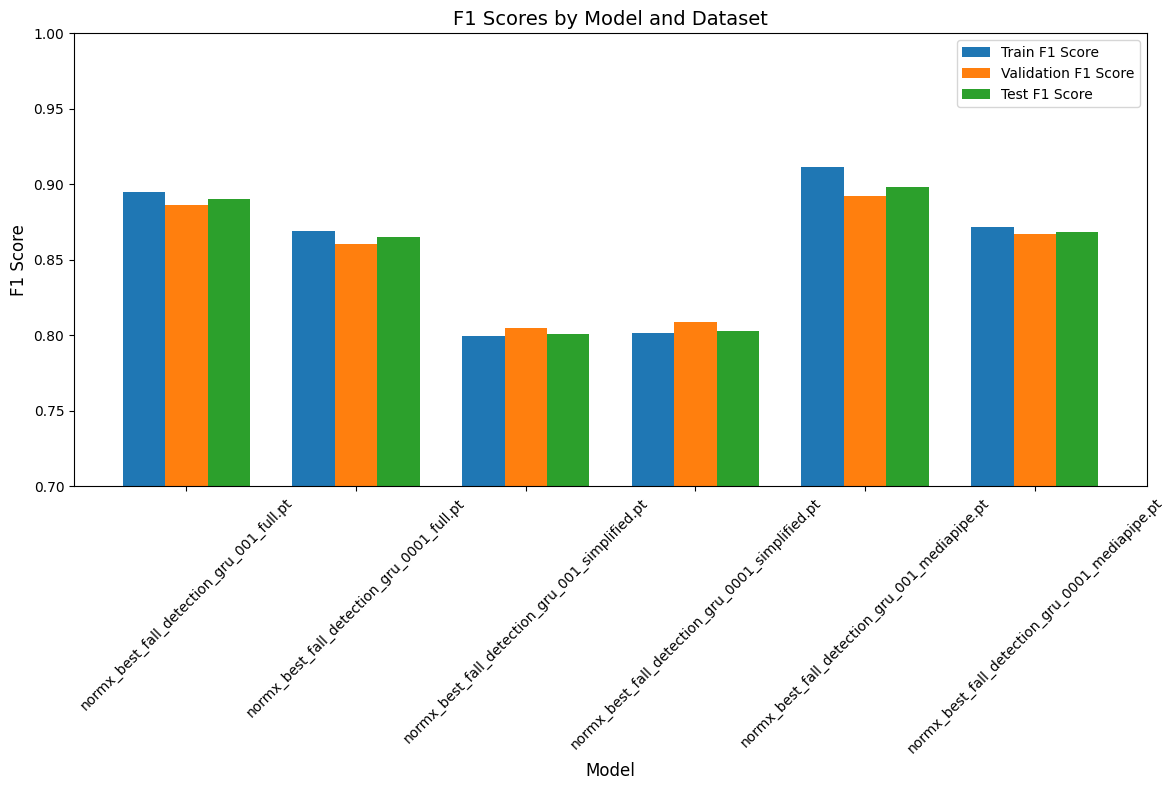

In [15]:
# 그래프용 데이터 변환
model_names = [result['Model'] for result in results]
train_scores = [result['Train'] for result in results]
val_scores = [result['Validation'] for result in results]
test_scores = [result['Test'] for result in results]

# 그래프 생성
plt.figure(figsize=(12, 8))
bar_width = 0.25
indices = range(len(model_names))

# 막대 그래프
plt.bar(indices, train_scores, bar_width, label="Train F1 Score")
plt.bar([i + bar_width for i in indices], val_scores, bar_width, label="Validation F1 Score")
plt.bar([i + 2 * bar_width for i in indices], test_scores, bar_width, label="Test F1 Score")

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Scores by Model and Dataset", fontsize=14)
plt.xticks([i + bar_width for i in indices], model_names, rotation=45, fontsize=10)
plt.ylim(0.7, 1.0)
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

In [16]:
# CNN 기반 낙상 감지 모델 정의
class FallDetectionCNN(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super(FallDetectionCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=22, out_channels=64, kernel_size=3, padding=1)  # mediapipe dataset을 공유하므로 in_channels은 22
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.transpose(1, 2)  # Conv1d의 형태를 맞추기 위함 (batch_size, channels, length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # tensor flattening
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
# 모델 준비
def create_cnn_model_for_dataset(dataset):
    if len(dataset) > 0:
        sample_sequence, sample_label = dataset[0]
        input_size = len(sample_sequence)  # CNN에서는 시퀀스 길이를 input size로 사용
        return FallDetectionCNN(input_size=input_size).to(device)
    else:
        print("데이터 없음")
        exit()

# 학습 및 검증 설정
cnn_model_configs = [
    ('normx_best_fall_detection_cnn_mediapipe_001.pt', 0.001),
    ('normx_best_fall_detection_cnn_mediapipe_0001.pt', 0.0001)
]

# 학습 파라미터 설정
num_epochs = 500
patience = 20

In [18]:
# 두 가지 학습률로 CNN 학습 진행
for cnn_model_name, learning_rate in cnn_model_configs:
    # 모델 생성
    model = create_cnn_model_for_dataset(train_mediapipe_dataset)
    model.to(device)

    # 손실 함수와 옵티마이저 정의
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0

    print(f"{cnn_model_name} 학습 시작 (lr={learning_rate})", flush=True)

    for epoch in range(num_epochs):
        model.train() # Training
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader_mediapipe, desc=f"Epoch {epoch + 1}/{num_epochs} (lr={learning_rate})"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()

            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader_mediapipe)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss (lr={learning_rate}): {avg_loss_train:.4f}')

        model.eval() # Validation
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader_mediapipe:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader_mediapipe)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss (lr={learning_rate}): {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), f'{pt_path}\\{cnn_model_name}')
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

normx_best_fall_detection_cnn_mediapipe_001.pt 학습 시작 (lr=0.001)


Epoch 1/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 549.71it/s]


Epoch [1/500], Train Loss (lr=0.001): 0.8085
Epoch [1/500], Valid Loss (lr=0.001): 0.7941


Epoch 2/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 576.45it/s]


Epoch [2/500], Train Loss (lr=0.001): 0.6647
Epoch [2/500], Valid Loss (lr=0.001): 0.5359


Epoch 3/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 584.17it/s]


Epoch [3/500], Train Loss (lr=0.001): 0.5856
Epoch [3/500], Valid Loss (lr=0.001): 0.5257


Epoch 4/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 585.60it/s]


Epoch [4/500], Train Loss (lr=0.001): 0.5635
Epoch [4/500], Valid Loss (lr=0.001): 0.5089


Epoch 5/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 590.94it/s]


Epoch [5/500], Train Loss (lr=0.001): 0.5451
Epoch [5/500], Valid Loss (lr=0.001): 0.4901


Epoch 6/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 588.79it/s]


Epoch [6/500], Train Loss (lr=0.001): 0.5296
Epoch [6/500], Valid Loss (lr=0.001): 0.5131


Epoch 7/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 592.03it/s]


Epoch [7/500], Train Loss (lr=0.001): 0.5306
Epoch [7/500], Valid Loss (lr=0.001): 0.5617


Epoch 8/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 589.18it/s]


Epoch [8/500], Train Loss (lr=0.001): 0.5178
Epoch [8/500], Valid Loss (lr=0.001): 0.5036


Epoch 9/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 582.11it/s]


Epoch [9/500], Train Loss (lr=0.001): 0.5138
Epoch [9/500], Valid Loss (lr=0.001): 0.5249


Epoch 10/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 592.64it/s]


Epoch [10/500], Train Loss (lr=0.001): 0.5129
Epoch [10/500], Valid Loss (lr=0.001): 0.5086


Epoch 11/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 585.88it/s]


Epoch [11/500], Train Loss (lr=0.001): 0.5068
Epoch [11/500], Valid Loss (lr=0.001): 0.4691


Epoch 12/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 583.66it/s]


Epoch [12/500], Train Loss (lr=0.001): 0.4988
Epoch [12/500], Valid Loss (lr=0.001): 0.4869


Epoch 13/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 587.07it/s]


Epoch [13/500], Train Loss (lr=0.001): 0.4974
Epoch [13/500], Valid Loss (lr=0.001): 0.4703


Epoch 14/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 592.26it/s]


Epoch [14/500], Train Loss (lr=0.001): 0.4975
Epoch [14/500], Valid Loss (lr=0.001): 0.4831


Epoch 15/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 585.54it/s]


Epoch [15/500], Train Loss (lr=0.001): 0.4962
Epoch [15/500], Valid Loss (lr=0.001): 0.4555


Epoch 16/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 588.58it/s]


Epoch [16/500], Train Loss (lr=0.001): 0.4861
Epoch [16/500], Valid Loss (lr=0.001): 0.4579


Epoch 17/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 591.39it/s]


Epoch [17/500], Train Loss (lr=0.001): 0.4902
Epoch [17/500], Valid Loss (lr=0.001): 0.4585


Epoch 18/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 588.79it/s]


Epoch [18/500], Train Loss (lr=0.001): 0.4851
Epoch [18/500], Valid Loss (lr=0.001): 0.4937


Epoch 19/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 592.04it/s]


Epoch [19/500], Train Loss (lr=0.001): 0.4866
Epoch [19/500], Valid Loss (lr=0.001): 0.4763


Epoch 20/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 591.98it/s]


Epoch [20/500], Train Loss (lr=0.001): 0.4801
Epoch [20/500], Valid Loss (lr=0.001): 0.4859


Epoch 21/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 591.18it/s]


Epoch [21/500], Train Loss (lr=0.001): 0.4833
Epoch [21/500], Valid Loss (lr=0.001): 0.4798


Epoch 22/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 590.52it/s]


Epoch [22/500], Train Loss (lr=0.001): 0.4445
Epoch [22/500], Valid Loss (lr=0.001): 0.4378


Epoch 23/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 584.94it/s]


Epoch [23/500], Train Loss (lr=0.001): 0.4405
Epoch [23/500], Valid Loss (lr=0.001): 0.4336


Epoch 24/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 584.09it/s]


Epoch [24/500], Train Loss (lr=0.001): 0.4374
Epoch [24/500], Valid Loss (lr=0.001): 0.4362


Epoch 25/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 581.97it/s]


Epoch [25/500], Train Loss (lr=0.001): 0.4354
Epoch [25/500], Valid Loss (lr=0.001): 0.4304


Epoch 26/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 583.88it/s]


Epoch [26/500], Train Loss (lr=0.001): 0.4355
Epoch [26/500], Valid Loss (lr=0.001): 0.4334


Epoch 27/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 582.12it/s]


Epoch [27/500], Train Loss (lr=0.001): 0.4340
Epoch [27/500], Valid Loss (lr=0.001): 0.4325


Epoch 28/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 587.07it/s]


Epoch [28/500], Train Loss (lr=0.001): 0.4312
Epoch [28/500], Valid Loss (lr=0.001): 0.4396


Epoch 29/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 586.53it/s]


Epoch [29/500], Train Loss (lr=0.001): 0.4306
Epoch [29/500], Valid Loss (lr=0.001): 0.4329


Epoch 30/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 580.60it/s]


Epoch [30/500], Train Loss (lr=0.001): 0.4295
Epoch [30/500], Valid Loss (lr=0.001): 0.4324


Epoch 31/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 583.24it/s]


Epoch [31/500], Train Loss (lr=0.001): 0.4290
Epoch [31/500], Valid Loss (lr=0.001): 0.4312


Epoch 32/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 583.66it/s]


Epoch [32/500], Train Loss (lr=0.001): 0.4236
Epoch [32/500], Valid Loss (lr=0.001): 0.4294


Epoch 33/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 587.18it/s]


Epoch [33/500], Train Loss (lr=0.001): 0.4223
Epoch [33/500], Valid Loss (lr=0.001): 0.4301


Epoch 34/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 587.93it/s]


Epoch [34/500], Train Loss (lr=0.001): 0.4228
Epoch [34/500], Valid Loss (lr=0.001): 0.4298


Epoch 35/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 581.68it/s]


Epoch [35/500], Train Loss (lr=0.001): 0.4218
Epoch [35/500], Valid Loss (lr=0.001): 0.4294


Epoch 36/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 587.07it/s]


Epoch [36/500], Train Loss (lr=0.001): 0.4230
Epoch [36/500], Valid Loss (lr=0.001): 0.4294


Epoch 37/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 574.49it/s]


Epoch [37/500], Train Loss (lr=0.001): 0.4221
Epoch [37/500], Valid Loss (lr=0.001): 0.4294


Epoch 38/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 583.66it/s]


Epoch [38/500], Train Loss (lr=0.001): 0.4210
Epoch [38/500], Valid Loss (lr=0.001): 0.4297


Epoch 39/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 587.65it/s]


Epoch [39/500], Train Loss (lr=0.001): 0.4223
Epoch [39/500], Valid Loss (lr=0.001): 0.4297


Epoch 40/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 589.23it/s]


Epoch [40/500], Train Loss (lr=0.001): 0.4202
Epoch [40/500], Valid Loss (lr=0.001): 0.4297


Epoch 41/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 590.72it/s]


Epoch [41/500], Train Loss (lr=0.001): 0.4233
Epoch [41/500], Valid Loss (lr=0.001): 0.4296


Epoch 42/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 588.43it/s]


Epoch [42/500], Train Loss (lr=0.001): 0.4193
Epoch [42/500], Valid Loss (lr=0.001): 0.4298


Epoch 43/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 584.65it/s]


Epoch [43/500], Train Loss (lr=0.001): 0.4219
Epoch [43/500], Valid Loss (lr=0.001): 0.4297


Epoch 44/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 583.02it/s]


Epoch [44/500], Train Loss (lr=0.001): 0.4227
Epoch [44/500], Valid Loss (lr=0.001): 0.4296


Epoch 45/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 583.85it/s]


Epoch [45/500], Train Loss (lr=0.001): 0.4217
Epoch [45/500], Valid Loss (lr=0.001): 0.4296


Epoch 46/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 585.27it/s]


Epoch [46/500], Train Loss (lr=0.001): 0.4210
Epoch [46/500], Valid Loss (lr=0.001): 0.4296


Epoch 47/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 580.00it/s]


Epoch [47/500], Train Loss (lr=0.001): 0.4215
Epoch [47/500], Valid Loss (lr=0.001): 0.4296


Epoch 48/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 581.66it/s]


Epoch [48/500], Train Loss (lr=0.001): 0.4210
Epoch [48/500], Valid Loss (lr=0.001): 0.4296


Epoch 49/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 582.52it/s]


Epoch [49/500], Train Loss (lr=0.001): 0.4200
Epoch [49/500], Valid Loss (lr=0.001): 0.4296


Epoch 50/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 582.76it/s]


Epoch [50/500], Train Loss (lr=0.001): 0.4199
Epoch [50/500], Valid Loss (lr=0.001): 0.4296


Epoch 51/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 586.29it/s]


Epoch [51/500], Train Loss (lr=0.001): 0.4208
Epoch [51/500], Valid Loss (lr=0.001): 0.4296


Epoch 52/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 586.91it/s]


Epoch [52/500], Train Loss (lr=0.001): 0.4205
Epoch [52/500], Valid Loss (lr=0.001): 0.4296


Epoch 53/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 587.14it/s]


Epoch [53/500], Train Loss (lr=0.001): 0.4211
Epoch [53/500], Valid Loss (lr=0.001): 0.4296


Epoch 54/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 585.78it/s]


Epoch [54/500], Train Loss (lr=0.001): 0.4215
Epoch [54/500], Valid Loss (lr=0.001): 0.4296


Epoch 55/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 584.48it/s]


Epoch [55/500], Train Loss (lr=0.001): 0.4199
Epoch [55/500], Valid Loss (lr=0.001): 0.4296


Epoch 56/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 588.80it/s]


Epoch [56/500], Train Loss (lr=0.001): 0.4202
Epoch [56/500], Valid Loss (lr=0.001): 0.4296


Epoch 57/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 589.49it/s]


Epoch [57/500], Train Loss (lr=0.001): 0.4207
Epoch [57/500], Valid Loss (lr=0.001): 0.4296
Early stopping
normx_best_fall_detection_cnn_mediapipe_0001.pt 학습 시작 (lr=0.0001)


Epoch 1/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 609.42it/s]


Epoch [1/500], Train Loss (lr=0.0001): 0.8342
Epoch [1/500], Valid Loss (lr=0.0001): 0.7788


Epoch 2/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 590.49it/s]


Epoch [2/500], Train Loss (lr=0.0001): 0.7737
Epoch [2/500], Valid Loss (lr=0.0001): 0.7662


Epoch 3/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 592.92it/s]


Epoch [3/500], Train Loss (lr=0.0001): 0.7560
Epoch [3/500], Valid Loss (lr=0.0001): 0.7323


Epoch 4/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 580.92it/s]


Epoch [4/500], Train Loss (lr=0.0001): 0.7256
Epoch [4/500], Valid Loss (lr=0.0001): 0.6712


Epoch 5/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 589.44it/s]


Epoch [5/500], Train Loss (lr=0.0001): 0.6598
Epoch [5/500], Valid Loss (lr=0.0001): 0.5981


Epoch 6/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 588.68it/s]


Epoch [6/500], Train Loss (lr=0.0001): 0.5853
Epoch [6/500], Valid Loss (lr=0.0001): 0.5135


Epoch 7/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 587.50it/s]


Epoch [7/500], Train Loss (lr=0.0001): 0.5470
Epoch [7/500], Valid Loss (lr=0.0001): 0.5003


Epoch 8/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 588.26it/s]


Epoch [8/500], Train Loss (lr=0.0001): 0.5355
Epoch [8/500], Valid Loss (lr=0.0001): 0.5014


Epoch 9/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 592.89it/s]


Epoch [9/500], Train Loss (lr=0.0001): 0.5296
Epoch [9/500], Valid Loss (lr=0.0001): 0.5178


Epoch 10/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 593.63it/s]


Epoch [10/500], Train Loss (lr=0.0001): 0.5127
Epoch [10/500], Valid Loss (lr=0.0001): 0.4863


Epoch 11/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 593.57it/s]


Epoch [11/500], Train Loss (lr=0.0001): 0.5138
Epoch [11/500], Valid Loss (lr=0.0001): 0.4697


Epoch 12/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 595.77it/s]


Epoch [12/500], Train Loss (lr=0.0001): 0.5026
Epoch [12/500], Valid Loss (lr=0.0001): 0.4579


Epoch 13/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 593.17it/s]


Epoch [13/500], Train Loss (lr=0.0001): 0.5003
Epoch [13/500], Valid Loss (lr=0.0001): 0.4620


Epoch 14/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 596.00it/s]


Epoch [14/500], Train Loss (lr=0.0001): 0.4949
Epoch [14/500], Valid Loss (lr=0.0001): 0.4529


Epoch 15/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 589.23it/s]


Epoch [15/500], Train Loss (lr=0.0001): 0.4928
Epoch [15/500], Valid Loss (lr=0.0001): 0.4450


Epoch 16/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 582.79it/s]


Epoch [16/500], Train Loss (lr=0.0001): 0.4823
Epoch [16/500], Valid Loss (lr=0.0001): 0.4878


Epoch 17/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 582.18it/s]


Epoch [17/500], Train Loss (lr=0.0001): 0.4794
Epoch [17/500], Valid Loss (lr=0.0001): 0.4448


Epoch 18/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 584.30it/s]


Epoch [18/500], Train Loss (lr=0.0001): 0.4825
Epoch [18/500], Valid Loss (lr=0.0001): 0.5079


Epoch 19/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 589.44it/s]


Epoch [19/500], Train Loss (lr=0.0001): 0.4778
Epoch [19/500], Valid Loss (lr=0.0001): 0.5023


Epoch 20/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 580.50it/s]


Epoch [20/500], Train Loss (lr=0.0001): 0.4728
Epoch [20/500], Valid Loss (lr=0.0001): 0.4335


Epoch 21/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 581.76it/s]


Epoch [21/500], Train Loss (lr=0.0001): 0.4698
Epoch [21/500], Valid Loss (lr=0.0001): 0.4259


Epoch 22/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 578.62it/s]


Epoch [22/500], Train Loss (lr=0.0001): 0.4655
Epoch [22/500], Valid Loss (lr=0.0001): 0.4362


Epoch 23/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 583.98it/s]


Epoch [23/500], Train Loss (lr=0.0001): 0.4576
Epoch [23/500], Valid Loss (lr=0.0001): 0.4434


Epoch 24/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 584.71it/s]


Epoch [24/500], Train Loss (lr=0.0001): 0.4579
Epoch [24/500], Valid Loss (lr=0.0001): 0.4435


Epoch 25/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 588.80it/s]


Epoch [25/500], Train Loss (lr=0.0001): 0.4553
Epoch [25/500], Valid Loss (lr=0.0001): 0.4452


Epoch 26/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 593.14it/s]


Epoch [26/500], Train Loss (lr=0.0001): 0.4509
Epoch [26/500], Valid Loss (lr=0.0001): 0.4536


Epoch 27/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 580.92it/s]


Epoch [27/500], Train Loss (lr=0.0001): 0.4479
Epoch [27/500], Valid Loss (lr=0.0001): 0.4260


Epoch 28/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 585.15it/s]


Epoch [28/500], Train Loss (lr=0.0001): 0.4136
Epoch [28/500], Valid Loss (lr=0.0001): 0.4086


Epoch 29/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 591.36it/s]


Epoch [29/500], Train Loss (lr=0.0001): 0.4104
Epoch [29/500], Valid Loss (lr=0.0001): 0.4027


Epoch 30/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 587.93it/s]


Epoch [30/500], Train Loss (lr=0.0001): 0.4094
Epoch [30/500], Valid Loss (lr=0.0001): 0.4021


Epoch 31/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 586.21it/s]


Epoch [31/500], Train Loss (lr=0.0001): 0.4096
Epoch [31/500], Valid Loss (lr=0.0001): 0.4019


Epoch 32/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 585.29it/s]


Epoch [32/500], Train Loss (lr=0.0001): 0.4073
Epoch [32/500], Valid Loss (lr=0.0001): 0.3976


Epoch 33/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 588.36it/s]


Epoch [33/500], Train Loss (lr=0.0001): 0.4073
Epoch [33/500], Valid Loss (lr=0.0001): 0.3991


Epoch 34/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 587.50it/s]


Epoch [34/500], Train Loss (lr=0.0001): 0.4078
Epoch [34/500], Valid Loss (lr=0.0001): 0.3982


Epoch 35/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 585.36it/s]


Epoch [35/500], Train Loss (lr=0.0001): 0.4059
Epoch [35/500], Valid Loss (lr=0.0001): 0.4018


Epoch 36/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 585.92it/s]


Epoch [36/500], Train Loss (lr=0.0001): 0.4052
Epoch [36/500], Valid Loss (lr=0.0001): 0.3972


Epoch 37/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 588.69it/s]


Epoch [37/500], Train Loss (lr=0.0001): 0.4042
Epoch [37/500], Valid Loss (lr=0.0001): 0.3965


Epoch 38/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 579.48it/s]


Epoch [38/500], Train Loss (lr=0.0001): 0.4044
Epoch [38/500], Valid Loss (lr=0.0001): 0.3980


Epoch 39/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 585.74it/s]


Epoch [39/500], Train Loss (lr=0.0001): 0.4027
Epoch [39/500], Valid Loss (lr=0.0001): 0.3988


Epoch 40/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 582.35it/s]


Epoch [40/500], Train Loss (lr=0.0001): 0.4007
Epoch [40/500], Valid Loss (lr=0.0001): 0.3946


Epoch 41/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 587.07it/s]


Epoch [41/500], Train Loss (lr=0.0001): 0.4003
Epoch [41/500], Valid Loss (lr=0.0001): 0.3976


Epoch 42/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 578.73it/s]


Epoch [42/500], Train Loss (lr=0.0001): 0.4018
Epoch [42/500], Valid Loss (lr=0.0001): 0.3949


Epoch 43/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 587.92it/s]


Epoch [43/500], Train Loss (lr=0.0001): 0.4018
Epoch [43/500], Valid Loss (lr=0.0001): 0.3940


Epoch 44/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 585.16it/s]


Epoch [44/500], Train Loss (lr=0.0001): 0.3989
Epoch [44/500], Valid Loss (lr=0.0001): 0.3934


Epoch 45/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 591.85it/s]


Epoch [45/500], Train Loss (lr=0.0001): 0.3995
Epoch [45/500], Valid Loss (lr=0.0001): 0.3935


Epoch 46/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 587.39it/s]


Epoch [46/500], Train Loss (lr=0.0001): 0.3984
Epoch [46/500], Valid Loss (lr=0.0001): 0.3924


Epoch 47/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 589.33it/s]


Epoch [47/500], Train Loss (lr=0.0001): 0.3989
Epoch [47/500], Valid Loss (lr=0.0001): 0.3925


Epoch 48/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 585.58it/s]


Epoch [48/500], Train Loss (lr=0.0001): 0.3962
Epoch [48/500], Valid Loss (lr=0.0001): 0.3912


Epoch 49/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 579.56it/s]


Epoch [49/500], Train Loss (lr=0.0001): 0.3980
Epoch [49/500], Valid Loss (lr=0.0001): 0.3924


Epoch 50/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 583.76it/s]


Epoch [50/500], Train Loss (lr=0.0001): 0.3948
Epoch [50/500], Valid Loss (lr=0.0001): 0.3904


Epoch 51/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 585.57it/s]


Epoch [51/500], Train Loss (lr=0.0001): 0.3962
Epoch [51/500], Valid Loss (lr=0.0001): 0.3900


Epoch 52/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 581.66it/s]


Epoch [52/500], Train Loss (lr=0.0001): 0.3961
Epoch [52/500], Valid Loss (lr=0.0001): 0.3889


Epoch 53/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 581.76it/s]


Epoch [53/500], Train Loss (lr=0.0001): 0.3911
Epoch [53/500], Valid Loss (lr=0.0001): 0.3913


Epoch 54/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 581.97it/s]


Epoch [54/500], Train Loss (lr=0.0001): 0.3958
Epoch [54/500], Valid Loss (lr=0.0001): 0.3924


Epoch 55/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 579.46it/s]


Epoch [55/500], Train Loss (lr=0.0001): 0.3933
Epoch [55/500], Valid Loss (lr=0.0001): 0.3909


Epoch 56/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 577.75it/s]


Epoch [56/500], Train Loss (lr=0.0001): 0.3930
Epoch [56/500], Valid Loss (lr=0.0001): 0.3870


Epoch 57/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 583.45it/s]


Epoch [57/500], Train Loss (lr=0.0001): 0.3943
Epoch [57/500], Valid Loss (lr=0.0001): 0.3886


Epoch 58/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 587.36it/s]


Epoch [58/500], Train Loss (lr=0.0001): 0.3903
Epoch [58/500], Valid Loss (lr=0.0001): 0.3887


Epoch 59/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 582.32it/s]


Epoch [59/500], Train Loss (lr=0.0001): 0.3910
Epoch [59/500], Valid Loss (lr=0.0001): 0.3880


Epoch 60/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 588.95it/s]


Epoch [60/500], Train Loss (lr=0.0001): 0.3917
Epoch [60/500], Valid Loss (lr=0.0001): 0.3892


Epoch 61/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 584.13it/s]


Epoch [61/500], Train Loss (lr=0.0001): 0.3891
Epoch [61/500], Valid Loss (lr=0.0001): 0.3871


Epoch 62/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 588.01it/s]


Epoch [62/500], Train Loss (lr=0.0001): 0.3903
Epoch [62/500], Valid Loss (lr=0.0001): 0.3846


Epoch 63/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 577.20it/s]


Epoch [63/500], Train Loss (lr=0.0001): 0.3899
Epoch [63/500], Valid Loss (lr=0.0001): 0.3921


Epoch 64/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 578.21it/s]


Epoch [64/500], Train Loss (lr=0.0001): 0.3881
Epoch [64/500], Valid Loss (lr=0.0001): 0.3886


Epoch 65/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 579.46it/s]


Epoch [65/500], Train Loss (lr=0.0001): 0.3878
Epoch [65/500], Valid Loss (lr=0.0001): 0.3862


Epoch 66/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 574.89it/s]


Epoch [66/500], Train Loss (lr=0.0001): 0.3877
Epoch [66/500], Valid Loss (lr=0.0001): 0.3884


Epoch 67/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 582.61it/s]


Epoch [67/500], Train Loss (lr=0.0001): 0.3872
Epoch [67/500], Valid Loss (lr=0.0001): 0.3885


Epoch 68/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 580.71it/s]


Epoch [68/500], Train Loss (lr=0.0001): 0.3863
Epoch [68/500], Valid Loss (lr=0.0001): 0.3855


Epoch 69/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 582.94it/s]


Epoch [69/500], Train Loss (lr=0.0001): 0.3828
Epoch [69/500], Valid Loss (lr=0.0001): 0.3836


Epoch 70/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 576.75it/s]


Epoch [70/500], Train Loss (lr=0.0001): 0.3804
Epoch [70/500], Valid Loss (lr=0.0001): 0.3829


Epoch 71/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 578.48it/s]


Epoch [71/500], Train Loss (lr=0.0001): 0.3792
Epoch [71/500], Valid Loss (lr=0.0001): 0.3835


Epoch 72/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 581.55it/s]


Epoch [72/500], Train Loss (lr=0.0001): 0.3829
Epoch [72/500], Valid Loss (lr=0.0001): 0.3831


Epoch 73/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 583.00it/s]


Epoch [73/500], Train Loss (lr=0.0001): 0.3825
Epoch [73/500], Valid Loss (lr=0.0001): 0.3827


Epoch 74/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 581.76it/s]


Epoch [74/500], Train Loss (lr=0.0001): 0.3798
Epoch [74/500], Valid Loss (lr=0.0001): 0.3836


Epoch 75/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 583.03it/s]


Epoch [75/500], Train Loss (lr=0.0001): 0.3809
Epoch [75/500], Valid Loss (lr=0.0001): 0.3828


Epoch 76/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 578.00it/s]


Epoch [76/500], Train Loss (lr=0.0001): 0.3812
Epoch [76/500], Valid Loss (lr=0.0001): 0.3828


Epoch 77/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 579.87it/s]


Epoch [77/500], Train Loss (lr=0.0001): 0.3816
Epoch [77/500], Valid Loss (lr=0.0001): 0.3826


Epoch 78/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 583.34it/s]


Epoch [78/500], Train Loss (lr=0.0001): 0.3821
Epoch [78/500], Valid Loss (lr=0.0001): 0.3830


Epoch 79/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 586.65it/s]


Epoch [79/500], Train Loss (lr=0.0001): 0.3817
Epoch [79/500], Valid Loss (lr=0.0001): 0.3834


Epoch 80/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 580.52it/s]


Epoch [80/500], Train Loss (lr=0.0001): 0.3815
Epoch [80/500], Valid Loss (lr=0.0001): 0.3823


Epoch 81/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 580.50it/s]


Epoch [81/500], Train Loss (lr=0.0001): 0.3806
Epoch [81/500], Valid Loss (lr=0.0001): 0.3821


Epoch 82/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 578.42it/s]


Epoch [82/500], Train Loss (lr=0.0001): 0.3813
Epoch [82/500], Valid Loss (lr=0.0001): 0.3826


Epoch 83/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 578.20it/s]


Epoch [83/500], Train Loss (lr=0.0001): 0.3817
Epoch [83/500], Valid Loss (lr=0.0001): 0.3824


Epoch 84/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 588.33it/s]


Epoch [84/500], Train Loss (lr=0.0001): 0.3819
Epoch [84/500], Valid Loss (lr=0.0001): 0.3829


Epoch 85/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 587.44it/s]


Epoch [85/500], Train Loss (lr=0.0001): 0.3818
Epoch [85/500], Valid Loss (lr=0.0001): 0.3827


Epoch 86/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 592.40it/s]


Epoch [86/500], Train Loss (lr=0.0001): 0.3812
Epoch [86/500], Valid Loss (lr=0.0001): 0.3821


Epoch 87/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 586.42it/s]


Epoch [87/500], Train Loss (lr=0.0001): 0.3830
Epoch [87/500], Valid Loss (lr=0.0001): 0.3822


Epoch 88/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 589.20it/s]


Epoch [88/500], Train Loss (lr=0.0001): 0.3808
Epoch [88/500], Valid Loss (lr=0.0001): 0.3823


Epoch 89/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 592.51it/s]


Epoch [89/500], Train Loss (lr=0.0001): 0.3800
Epoch [89/500], Valid Loss (lr=0.0001): 0.3823


Epoch 90/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 583.95it/s]


Epoch [90/500], Train Loss (lr=0.0001): 0.3806
Epoch [90/500], Valid Loss (lr=0.0001): 0.3824


Epoch 91/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 588.96it/s]


Epoch [91/500], Train Loss (lr=0.0001): 0.3826
Epoch [91/500], Valid Loss (lr=0.0001): 0.3823


Epoch 92/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 588.87it/s]


Epoch [92/500], Train Loss (lr=0.0001): 0.3804
Epoch [92/500], Valid Loss (lr=0.0001): 0.3824


Epoch 93/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 586.86it/s]


Epoch [93/500], Train Loss (lr=0.0001): 0.3796
Epoch [93/500], Valid Loss (lr=0.0001): 0.3824


Epoch 94/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 581.72it/s]


Epoch [94/500], Train Loss (lr=0.0001): 0.3796
Epoch [94/500], Valid Loss (lr=0.0001): 0.3824


Epoch 95/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 593.14it/s]


Epoch [95/500], Train Loss (lr=0.0001): 0.3820
Epoch [95/500], Valid Loss (lr=0.0001): 0.3823


Epoch 96/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 576.67it/s]


Epoch [96/500], Train Loss (lr=0.0001): 0.3806
Epoch [96/500], Valid Loss (lr=0.0001): 0.3823


Epoch 97/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:03<00:00, 525.25it/s]


Epoch [97/500], Train Loss (lr=0.0001): 0.3802
Epoch [97/500], Valid Loss (lr=0.0001): 0.3823


Epoch 98/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:03<00:00, 533.09it/s]


Epoch [98/500], Train Loss (lr=0.0001): 0.3803
Epoch [98/500], Valid Loss (lr=0.0001): 0.3823


Epoch 99/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 543.98it/s]


Epoch [99/500], Train Loss (lr=0.0001): 0.3806
Epoch [99/500], Valid Loss (lr=0.0001): 0.3823


Epoch 100/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 548.17it/s]


Epoch [100/500], Train Loss (lr=0.0001): 0.3800
Epoch [100/500], Valid Loss (lr=0.0001): 0.3823


Epoch 101/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 543.26it/s]


Epoch [101/500], Train Loss (lr=0.0001): 0.3816
Epoch [101/500], Valid Loss (lr=0.0001): 0.3823
Early stopping


In [19]:
# 학습, 검증, 테스트 데이터셋 평가
results_2 = []
for cnn_model_name, _ in cnn_model_configs:
    # 모델 생성 (각 모델의 input에 맞게 dataset 전달)
    model = create_cnn_model_for_dataset(train_mediapipe_dataset)
    model.load_state_dict(torch.load(f'{pt_path}\\{cnn_model_name}', weights_only=True))
    model.to(device)

    # 데이터셋별 평가
    scores = {'Model': cnn_model_name}
    for loader_name, data_loader in [('Train', train_loader_mediapipe), ('Validation', valid_loader_mediapipe), ('Test', test_loader_mediapipe)]:
        f1, cm = calculate_metrics(model, data_loader)
        print(f"{cnn_model_name} ({loader_name}): F1 Score: {f1:.4f}")
        print(f"Confusion Matrix ({loader_name}):\n{cm}")
        scores[loader_name] = f1
    results_2.append(scores)

normx_best_fall_detection_cnn_mediapipe_001.pt (Train): F1 Score: 0.8690
Confusion Matrix (Train):
[[25413  2254  2374]
 [  502  2749   427]
 [  784   726 16198]]
normx_best_fall_detection_cnn_mediapipe_001.pt (Validation): F1 Score: 0.8620
Confusion Matrix (Validation):
[[3083  298  319]
 [  57  389   50]
 [  98  109 2025]]
normx_best_fall_detection_cnn_mediapipe_001.pt (Test): F1 Score: 0.8686
Confusion Matrix (Test):
[[3109  289  300]
 [  67  379   49]
 [  96   80 2060]]
normx_best_fall_detection_cnn_mediapipe_0001.pt (Train): F1 Score: 0.8879
Confusion Matrix (Train):
[[26073  2121  1847]
 [  430  2842   406]
 [  551   724 16433]]
normx_best_fall_detection_cnn_mediapipe_0001.pt (Validation): F1 Score: 0.8774
Confusion Matrix (Validation):
[[3163  286  251]
 [  54  391   51]
 [  77  113 2042]]
normx_best_fall_detection_cnn_mediapipe_0001.pt (Test): F1 Score: 0.8850
Confusion Matrix (Test):
[[3198  271  229]
 [  65  383   47]
 [  78   85 2073]]


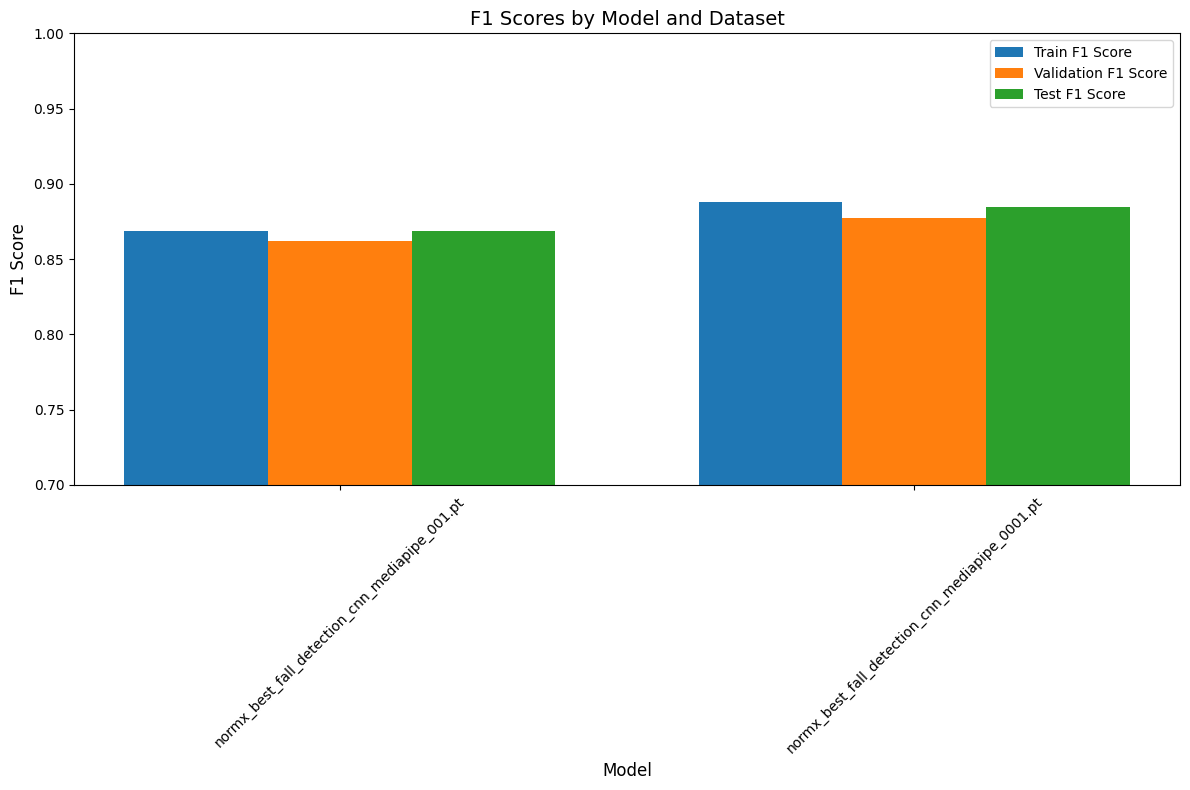

In [20]:
# 그래프용 데이터 변환
model_names = [result['Model'] for result in results_2]
train_scores = [result['Train'] for result in results_2]
val_scores = [result['Validation'] for result in results_2]
test_scores = [result['Test'] for result in results_2]

# 그래프 생성
plt.figure(figsize=(12, 8))
bar_width = 0.25
indices = range(len(model_names))

# 막대 그래프
plt.bar(indices, train_scores, bar_width, label="Train F1 Score")
plt.bar([i + bar_width for i in indices], val_scores, bar_width, label="Validation F1 Score")
plt.bar([i + 2 * bar_width for i in indices], test_scores, bar_width, label="Test F1 Score")

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Scores by Model and Dataset", fontsize=14)
plt.xticks([i + bar_width for i in indices], model_names, rotation=45, fontsize=10)
plt.ylim(0.7, 1.0)
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

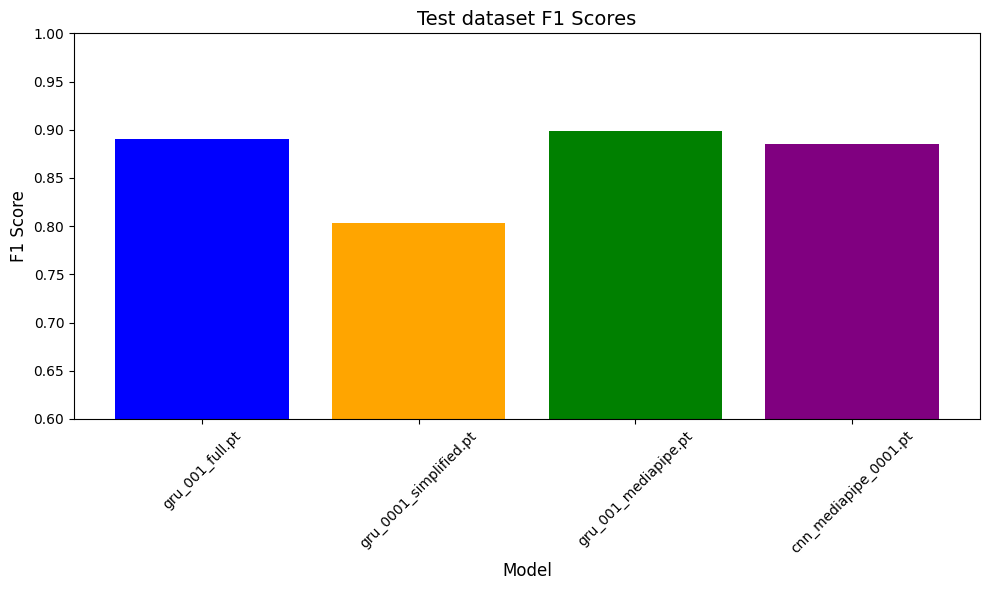

In [2]:
model_f1_scores = [
    ('normx_best_fall_detection_gru_001_full.pt', 0.8905),
    ('normx_best_fall_detection_gru_0001_simplified.pt', 0.8030),
    ('normx_best_fall_detection_gru_001_mediapipe.pt', 0.8984),
    ('normx_best_fall_detection_cnn_mediapipe_0001.pt', 0.8850)
]

# 모델명과 Test F1 Scores를 분리하여 리스트로 저장
model_names = [name.split('best_fall_detection_')[1] for name, _ in model_f1_scores]
train_f1_scores = [x[1] for x in model_f1_scores]

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(model_names, train_f1_scores, color=['blue', 'orange', 'green', 'purple'])

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("Test dataset F1 Scores", fontsize=14)
plt.ylim(0.6, 1.0)

# x축 라벨의 가독성을 위해 회전 추가
plt.xticks(rotation=45, fontsize=10)

# 그래프 출력
plt.tight_layout()
plt.show()